In [1]:
import os
import pandas as pd
from nlpipe import NlPipe
import numpy as np
import os
from tqdm.auto import tqdm
import logging
from threadpoolctl import threadpool_limits
import pickle
from IPython.display import display
from IPython.core.display import HTML
from gensim.models.wrappers.ldamallet import malletmodel2ldamodel
from gensim.models.wrappers import LdaMallet
import pyLDAvis
from collections import Counter, OrderedDict


def filter_on_stats(stat_df, min_replies=10, max_replies=350, language='en', acyclic=True):
    filter_array = np.logical_and(stat_df.replies >= min_replies ,stat_df.language == language)
    filter_array = np.logical_and(filter_array, stat_df.is_acyclic == acyclic)
    filter_array = np.logical_and(filter_array,stat_df.replies <= max_replies)
    filter_array = filter_array.to_numpy()
    return filter_array
path = "b_collection_extracted/"

## Ausgabe berechneter Coherence Scores

In [2]:
with open(f"{path}coherence_results_mallet", "rb") as f:
    coherences = pickle.load(f)

In [3]:
coherences

{'mallet-no=5-filter=True-min_df=105.121-max_df=0.3-phrases=None-k_n=100000-k_t=None': {'c_v': 0.4812077964460986},
 'best_score': 0.5421969031049485,
 'best_model': <gensim.models.wrappers.ldamallet.LdaMallet at 0x7fc918ec8dd8>,
 'best_topic_no': 20,
 'best_alpha': array([2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5,
        2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5]),
 'mallet-no=10-filter=True-min_df=105.121-max_df=0.3-phrases=None-k_n=100000-k_t=None': {'c_v': 0.5101931898288266},
 'mallet-no=15-filter=True-min_df=105.121-max_df=0.3-phrases=None-k_n=100000-k_t=None': {'c_v': 0.5122058451092564},
 'mallet-no=20-filter=True-min_df=105.121-max_df=0.3-phrases=None-k_n=100000-k_t=None': {'c_v': 0.5421969031049485},
 'mallet-no=25-filter=True-min_df=105.121-max_df=0.3-phrases=None-k_n=100000-k_t=None': {'c_v': 0.5154006518971267},
 'mallet-no=30-filter=True-min_df=105.121-max_df=0.3-phrases=None-k_n=100000-k_t=None': {'c_v': 0.5317904529441941},
 'mallet-no=35-filter=True-min_

## Mallet LDA mit 20 Topics

Bestes Model nach Score ist bei 20 Topics

In [4]:
stat_df = pd.read_pickle(f"{path}stat_df")
if os.path.exists(f"{path}text_df"):
    print("text df found. loading.")
    text_df = pd.read_pickle(f"{path}text_df")
    texts = text_df.full_text.to_list()
    thread_ids = text_df.thread_id.to_list()
else:
    thread_ids = stat_df.thread_id.to_list()
    post_df = pd.read_pickle(f"{path}post_df_extracted")
    thread_id_of_posts = np.array(post_df.thread_id, dtype=np.uint32)
    texts = [" ".join(post_df.full_string[thread_id_of_posts == thread_id].tolist()) for thread_id in thread_ids]
    post_df = None
    text_df = pd.DataFrame([thread_ids, texts]).transpose()
    text_df.columns = ['thread_id', 'full_text']
    text_df.to_pickle(f"{path}text_df")

text df found. loading.


Um das Modell erneut zu trainieren, folgende Zelle ausführen. 

In [5]:
nlp = NlPipe.NlPipe(texts, path=path, document_ids=thread_ids, no_processes=10)
filter_array = np.logical_and(stat_df.language == 'en',
                              stat_df.replies >= 10)
filter_array = np.logical_and(filter_array,
                              stat_df.replies <= 350)
filter_array = np.logical_and(filter_array,
                              stat_df.is_acyclic)
print(f"{len(filter_array)} is limiting to {sum(filter_array)}")
nlp.preprocess(load_existing=True, filter_loaded=filter_array)
nlp.create_bag_of_words(filter_extremes=True, min_df=int(0.001*sum(filter_array)), max_df=0.3)

nlp.create_mallet_lda_model(no_topics=20, custom_prefix="20tops")
coherence_mallet = nlp.calculate_coherence()
coherence_mallet = coherence_mallet.get_coherence()
print(f"Coherence score for MALLET in this run is {coherence_mallet}")

326538 is limiting to 105100
Found preprocessed data. Loading
105100 preprocessed docs of 326538 docs loaded.


Creating bag of words:   0%|          | 0/105100 [00:00<?, ?it/s]

Coherence score for MALLET in this run is 0.5086942988836909


Um das trainierte Modell erneut zu laden, folgende Zelle ausführen. 

In [ ]:
nlp = NlPipe.NlPipe(texts, path=path, document_ids=thread_ids, no_processes=10)
filter_array = np.logical_and(stat_df.language == 'en',
                              stat_df.replies >= 10)
filter_array = np.logical_and(filter_array,
                              stat_df.replies <= 350)
filter_array = np.logical_and(filter_array,
                              stat_df.is_acyclic)
print(f"{len(filter_array)} is limiting to {sum(filter_array)}")
nlp.preprocess(load_existing=True, filter_loaded=filter_array)
nlp.create_bag_of_words(filter_extremes=True, min_df=int(0.001*sum(filter_array)), max_df=0.3)
nlp.lda_model = LdaMallet.load("b_collection_extracted/mallet_model_20_topics")

In [6]:
# mallet with 20 topics
for topic_no, word_list in nlp.lda_model.show_topics(num_topics=20, num_words= 30, formatted=False):
    print(topic_no, [word[0] for word in word_list])

0 ['eat', 'drink', 'water', 'food', 'smell', 'fat', 'taste', 'clean', 'meat', 'cook', 'piss', 'toilet', 'chicken', 'pizza', 'beer', 'sauce', 'buy', 'cut', 'wash', 'milk', 'cheese', 'skin', 'egg', 'grow', 'bite', 'tooth', 'poop', 'dry', 'fish', 'bottle']
1 ['dog', 'retard', 'kill', 'kek', 'bitch', 'lose', 'funny', 'kid', 'kys', 'fucking', 'dude', 'loser', 'fag', 'laugh', 'meme', 'animal', 'stupid', 'cat', 'die', 'dead', 'chan', 'joke', 'dad', 'cunt', 'father', 'cringe', 'nigga', 'late', 'mother', 'lmao']
2 ['trump', 'vote', 'retard', 'president', 'country', 'american', 'state', 'tds', 'liberal', 'biden', 'win', 'government', 'america', 'party', 'stupid', 'democrat', 'republican', 'support', 'obama', 'literally', 'news', 'political', 'wrong', 'point', 'lose', 'fact', 'lie', 'conservative', 'medium', 'idiot']
3 ['kik', 'send', 'gf', 'wife', 'nude', 'share', 'cock', 'trade', 'cum', 'slut', 'rate', 'teen', 'vids', 'sister', 'limit', 'cuck', 'tribute', 'snap', 'jerk', 'wanna', 'chat', 'add',

In [7]:
nlp.create_document_topic_df(model=nlp.lda_model)
nlp.result_df

0         1         2         3         4         5  \
830097224  0.037051  0.022928  0.018190  0.000000  0.329149  0.020258   
828635931  0.049020  0.049020  0.049020  0.049182  0.068408  0.049020   
828806746  0.032071  0.038633  0.072025  0.028706  0.030556  0.036756   
828629011  0.014446  0.251060  0.013481  0.059829  0.141474  0.030384   
828822496  0.028662  0.055851  0.128970  0.061233  0.113967  0.030103   
...             ...       ...       ...       ...       ...       ...   
831569096  0.039164  0.031775  0.028262  0.025739  0.031378  0.111469   
830755068  0.000000  0.028947  0.151204  0.000000  0.000000  0.043736   
828459235  0.020987  0.020850  0.000000  0.000000  0.020736  0.245779   
828957946  0.023606  0.028881  0.013878  0.027145  0.035768  0.016553   
830864445  0.028715  0.038382  0.027670  0.077051  0.071484  0.029391   

                  6         7         8         9  ...        11        12  \
830097224  0.040648  0.051258  0.027013  0.101536  ...  0.017634  0.019684   
828635931  0.049020  0.049020  0.049020  0.049020  ...  0.049020  0.049020   
828806746  0.037267  0.030372  0.174993  0.029719  ...  0.031602  0.028098   
828629011  0.141135  0.023445  0.000000  0.045071  ...  0.000000  0.016807   
828822496  0.038423  0.032932  0.038147  0.071043  ...  0.026983  0.055526   
...             ...       ...       ...       ...  ...       ...       ...   
831569096  0.023536  0.027176  0.071944  0.027165  ...  0.052872  0.033063   
830755068  0.084799  0.010438  0.028169  0.013511  ...  0.047951  0.000000   
828459235  0.157392  0.019472  0.015906  0.320199  ...  0.010821  0.000000   
828957946  0.031625  0.025970  0.022216  0.057812  ...  0.047133  0.292078   
830864445  0.026493  0.032713  0.027780  0.033387  ...  0.031859  0.054619   

                 13        14        15        16        17        18  \
830097224  0.035785  0.019994  0.085983  0.058109  0.073910  0.016372   
828635931  0.049020  0.049077  0.049020  0.049020  0.049020  0.049020   
828806746  0.033879  0.028831  0.056091  0.027797  0.027767  0.042066   
828629011  0.070335  0.036985  0.000000  0.084959  0.025231  0.000000   
828822496  0.061635  0.047417  0.046824  0.036337  0.028205  0.040844   
...             ...       ...       ...       ...       ...       ...   
831569096  0.114090  0.033593  0.030401  0.029690  0.208559  0.025085   
830755068  0.014556  0.000000  0.041607  0.000000  0.000000  0.411854   
828459235  0.000000  0.014994  0.019865  0.000000  0.036677  0.035143   
828957946  0.059193  0.067158  0.013564  0.158725  0.022639  0.018465   
830864445  0.030734  0.040909  0.044977  0.237215  0.058257  0.027376   

                 19  dominant_topic  
830097224  0.011472               4  
828635931  0.049020               4  
828806746  0.034995              10  
828629011  0.000000               1  
828822496  0.024882               2  
...             ...             ...  
831569096  0.025788              17  
830755068  0.000000              18  
828459235  0.000000               9  
828957946  0.018203              12  
830864445  0.054022              16  

[105100 rows x 21 columns]

0         1         2         3         4         5  \
830097224  0.037051  0.022927  0.018190  0.000000  0.329149  0.020256   
828635931  0.049020  0.049020  0.049020  0.049182  0.068407  0.049020   
828806746  0.032072  0.038639  0.072038  0.028706  0.030556  0.036756   
828629011  0.014445  0.251061  0.013480  0.059829  0.141473  0.030385   
828822496  0.028662  0.055856  0.128972  0.061245  0.113967  0.030103   
...             ...       ...       ...       ...       ...       ...   
831569096  0.039165  0.031775  0.028262  0.025739  0.031378  0.111466   
830755068  0.000000  0.028942  0.151207  0.000000  0.000000  0.043736   
828459235  0.020987  0.020850  0.000000  0.000000  0.020736  0.245780   
828957946  0.023607  0.028888  0.013879  0.027151  0.035771  0.016553   
830864445  0.028715  0.038384  0.027670  0.077083  0.071461  0.029391   

                  6         7         8         9  ...        11        12  \
830097224  0.040645  0.051256  0.027014  0.101533  ...  0.017628  0.019684   
828635931  0.049020  0.049020  0.049020  0.049020  ...  0.049020  0.049020   
828806746  0.037269  0.030373  0.174962  0.029719  ...  0.031602  0.028098   
828629011  0.141135  0.023445  0.000000  0.045070  ...  0.000000  0.016805   
828822496  0.038425  0.032932  0.038147  0.071050  ...  0.026983  0.055517   
...             ...       ...       ...       ...  ...       ...       ...   
831569096  0.023536  0.027176  0.071944  0.027165  ...  0.052871  0.033063   
830755068  0.084795  0.010438  0.028169  0.013511  ...  0.047950  0.000000   
828459235  0.157387  0.019472  0.015906  0.320200  ...  0.010821  0.000000   
828957946  0.031625  0.025978  0.022216  0.057824  ...  0.047165  0.292094   
830864445  0.026493  0.032714  0.027781  0.033387  ...  0.031858  0.054616   

                 13        14        15        16        17        18  \
830097224  0.035809  0.019993  0.085980  0.058108  0.073906  0.016373   
828635931  0.049020  0.049077  0.049020  0.049020  0.049020  0.049020   
828806746  0.033882  0.028831  0.056086  0.027797  0.027767  0.042068   
828629011  0.070333  0.036991  0.000000  0.084959  0.025230  0.000000   
828822496  0.061616  0.047417  0.046824  0.036338  0.028205  0.040842   
...             ...       ...       ...       ...       ...       ...   
831569096  0.114098  0.033593  0.030401  0.029690  0.208555  0.025085   
830755068  0.014562  0.000000  0.041606  0.000000  0.000000  0.411855   
828459235  0.000000  0.014995  0.019866  0.000000  0.036675  0.035147   
828957946  0.059149  0.067106  0.013564  0.158734  0.022646  0.018460   
830864445  0.030733  0.040914  0.044979  0.237212  0.058251  0.027376   

                 19  dominant_topic  
830097224  0.011471               4  
828635931  0.049020               4  
828806746  0.034995              10  
828629011  0.000000               1  
828822496  0.024883               2  
...             ...             ...  
831569096  0.025788              17  
830755068  0.000000              18  
828459235  0.000000               9  
828957946  0.018204              12  
830864445  0.054016              16  

[105100 rows x 21 columns]

In [8]:
nlp.result_df.to_pickle("b_collection_extracted/document_result_df_20tops")

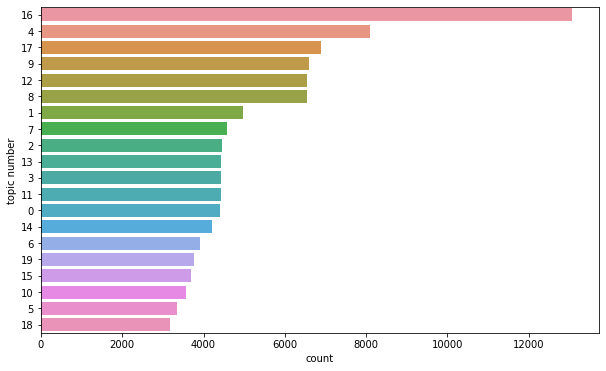

In [9]:
nlp.plot_document_topic_distribution()

In [10]:
with open("b_collection_extracted/mallet_model_20_topics", "wb") as f:
    nlp.lda_model.save(f)

In [11]:
model = malletmodel2ldamodel(nlp.lda_model)
panel = pyLDAvis.gensim.prepare(model, nlp.bag_of_words, nlp.id2word)
with open("b_collection_extracted/pyldavis20tops.html", "w") as f:
    pyLDAvis.save_html(data=panel, fileobj=f)
display(HTML(filename="b_collection_extracted/pyldavis20tops.html"))

/home/hengelhardt/masterarbeit/.venv/lib/python3.6/site-packages/pyLDAvis/_prepare.py:223: RuntimeWarning: divide by zero encountered in log
  kernel = (topic_given_term * np.log((topic_given_term.T / topic_proportion).T))
/home/hengelhardt/masterarbeit/.venv/lib/python3.6/site-packages/pyLDAvis/_prepare.py:240: RuntimeWarning: divide by zero encountered in log
  log_lift = np.log(topic_term_dists / term_proportion)
/home/hengelhardt/masterarbeit/.venv/lib/python3.6/site-packages/pyLDAvis/_prepare.py:241: RuntimeWarning: divide by zero encountered in log
  log_ttd = np.log(topic_term_dists)


## Mallet LDA mit 25 Topics

Um das Modell erneut zu trainieren, folgende Zelle ausführen. 

In [12]:
nlp = NlPipe.NlPipe(texts, path=path, document_ids=thread_ids, no_processes=10)
filter_array = np.logical_and(stat_df.language == 'en',
                              stat_df.replies >= 10)
filter_array = np.logical_and(filter_array,
                              stat_df.replies <= 350)
filter_array = np.logical_and(filter_array,
                              stat_df.is_acyclic)
print(f"{len(filter_array)} is limiting to {sum(filter_array)}")
nlp.preprocess(load_existing=True, filter_loaded=filter_array)
nlp.create_bag_of_words(filter_extremes=True, min_df=int(0.001*sum(filter_array)), max_df=0.3)

nlp.create_mallet_lda_model(no_topics=25, custom_prefix="25tops")
coherence_mallet = nlp.calculate_coherence()
coherence_mallet = coherence_mallet.get_coherence()
print(f"Coherence score for MALLET in this run is {coherence_mallet}")

326538 is limiting to 105100
Found preprocessed data. Loading
105100 preprocessed docs of 326538 docs loaded.


Creating bag of words:   0%|          | 0/105100 [00:00<?, ?it/s]

Coherence score for MALLET in this run is 0.5252877768787874


Um das bereits trainierte Modell zu laden, folgende Zelle ausführen. 

In [ ]:
nlp = NlPipe.NlPipe(texts, path=path, document_ids=thread_ids, no_processes=10)
filter_array = np.logical_and(stat_df.language == 'en',
                              stat_df.replies >= 10)
filter_array = np.logical_and(filter_array,
                              stat_df.replies <= 350)
filter_array = np.logical_and(filter_array,
                              stat_df.is_acyclic)
print(f"{len(filter_array)} is limiting to {sum(filter_array)}")
nlp.preprocess(load_existing=True, filter_loaded=filter_array)
nlp.create_bag_of_words(filter_extremes=True, min_df=int(0.001*sum(filter_array)), max_df=0.3)
nlp.lda_model = LdaMallet.load("b_collection_extracted/mallet_model_25_topics")

In [13]:
for topic_no, word_list in nlp.lda_model.show_topics(num_topics=25, num_words= 30, formatted=False):
    print(topic_no, [word[0] for word in word_list])

0 ['child', 'rape', 'kid', 'loli', 'age', 'sex', 'porn', 'boy', 'pedo', 'young', 'real', 'sexual', 'wrong', 'adult', 'pedophile', 'shota', 'fetish', 'stuff', 'woman', 'lolis', 'abuse', 'legal', 'consent', 'diaper', 'baby', 'pedos', 'image', 'imagine', 'illegal', 'fantasy']
1 ['game', 'play', 'watch', 'movie', 'music', 'great', 'listen', 'character', 'story', 'fun', 'end', 'song', 'read', 'cool', 'remember', 'lot', 'write', 'favorite', 'base', 'list', 'hear', 'star', 'band', 'sound', 'film', 'enjoy', 'video', 'metal', 'stuff', 'fan']
2 ['kik', 'send', 'gf', 'wife', 'nude', 'cock', 'share', 'trade', 'cum', 'slut', 'teen', 'rate', 'cuck', 'limit', 'sister', 'tribute', 'vids', 'wanna', 'chat', 'jerk', 'oc', 'stuff', 'add', 'trib', 'bonus', 'friend', 'bull', 'talk', 'snap', 'expose']
3 ['bitch', 'kek', 'lose', 'funny', 'coof', 'retard', 'dude', 'kid', 'loser', 'kys', 'fucking', 'laugh', 'dad', 'haha', 'nigga', 'fag', 'late', 'father', 'cunt', 'mother', 'meme', 'lmao', 'chan', 'joke', 'stupi

In [14]:
nlp.create_document_topic_df(model=nlp.lda_model)
nlp.result_df

0         1         2         3         4         5  \
830097224  0.069882  0.076534  0.000000  0.022479  0.051844  0.028320   
828635931  0.058724  0.039216  0.039315  0.039216  0.039216  0.039216   
828806746  0.025240  0.024693  0.023191  0.025465  0.022335  0.157147   
828629011  0.053437  0.017086  0.046074  0.184290  0.077461  0.000000   
828822496  0.118044  0.026436  0.035450  0.063474  0.026982  0.026594   
...             ...       ...       ...       ...       ...       ...   
831569096  0.020463  0.020579  0.021007  0.028131  0.022588  0.047008   
830755068  0.017760  0.000000  0.000000  0.024322  0.000000  0.039147   
828459235  0.000000  0.024387  0.000000  0.010963  0.000000  0.016019   
828957946  0.017050  0.014455  0.026351  0.020430  0.101422  0.015091   
830864445  0.023502  0.027643  0.054468  0.037310  0.206633  0.021941   

                  6         7         8         9  ...        16        17  \
830097224  0.011417  0.017548  0.034530  0.066570  ...  0.067381  0.026977   
828635931  0.039216  0.039216  0.039216  0.039216  ...  0.039216  0.039216   
828806746  0.030441  0.028016  0.165846  0.022658  ...  0.052225  0.022290   
828629011  0.018914  0.049973  0.150124  0.023965  ...  0.000000  0.000000   
828822496  0.021446  0.039645  0.027595  0.025221  ...  0.033585  0.027549   
...             ...       ...       ...       ...  ...       ...       ...   
831569096  0.112389  0.095555  0.022173  0.206631  ...  0.023813  0.036129   
830755068  0.043475  0.011113  0.032861  0.000000  ...  0.040064  0.000000   
828459235  0.194791  0.000000  0.022030  0.013759  ...  0.018120  0.000000   
828957946  0.014687  0.031673  0.035531  0.015752  ...  0.010223  0.296874   
830864445  0.024846  0.024017  0.021404  0.023308  ...  0.034882  0.098338   

                 18        19        20        21        22        23  \
830097224  0.013597  0.013132  0.029332  0.000000  0.000000  0.010996   
828635931  0.039216  0.039216  0.039216  0.039216  0.039216  0.039216   
828806746  0.031558  0.056152  0.022619  0.058254  0.029106  0.023052   
828629011  0.000000  0.000000  0.027140  0.000000  0.049649  0.021775   
828822496  0.025369  0.108135  0.036802  0.024343  0.029114  0.084837   
...             ...       ...       ...       ...       ...       ...   
831569096  0.020076  0.023088  0.031757  0.022851  0.019949  0.023387   
830755068  0.385584  0.140155  0.000000  0.070907  0.088001  0.000000   
828459235  0.023719  0.000000  0.297269  0.021165  0.155764  0.000000   
828957946  0.017248  0.000000  0.025955  0.000000  0.012190  0.015238   
830864445  0.021859  0.021881  0.024276  0.021363  0.020662  0.039778   

                 24  dominant_topic  
830097224  0.010017              12  
828635931  0.039216               0  
828806746  0.025073               8  
828629011  0.010953               3  
828822496  0.024508               0  
...             ...             ...  
831569096  0.038741               9  
830755068  0.000000              18  
828459235  0.000000              20  
828957946  0.014456              17  
830864445  0.023700               4  

[105100 rows x 26 columns]

In [15]:
nlp.result_df.to_pickle("b_collection_extracted/document_result_df_25tops")

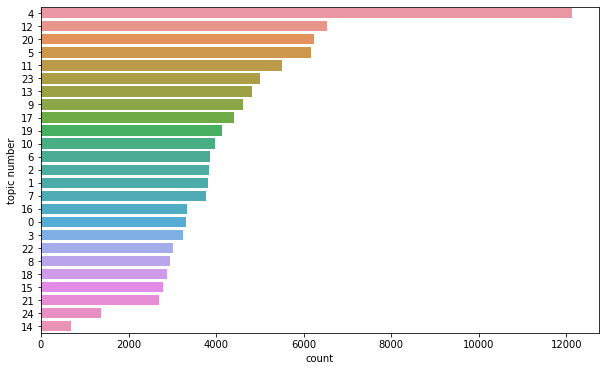

In [16]:
nlp.plot_document_topic_distribution()

In [17]:
with open("b_collection_extracted/mallet_model_25_topics", "wb") as f:
    nlp.lda_model.save(f)

In [18]:
model = malletmodel2ldamodel(nlp.lda_model)
panel = pyLDAvis.gensim.prepare(model, nlp.bag_of_words, nlp.id2word)
with open("b_collection_extracted/pyldavis25tops.html", "w") as f:
    pyLDAvis.save_html(data=panel, fileobj=f)
display(HTML(filename="b_collection_extracted/pyldavis25tops.html"))

/home/hengelhardt/masterarbeit/.venv/lib/python3.6/site-packages/pyLDAvis/_prepare.py:223: RuntimeWarning: divide by zero encountered in log
  kernel = (topic_given_term * np.log((topic_given_term.T / topic_proportion).T))
/home/hengelhardt/masterarbeit/.venv/lib/python3.6/site-packages/pyLDAvis/_prepare.py:240: RuntimeWarning: divide by zero encountered in log
  log_lift = np.log(topic_term_dists / term_proportion)
/home/hengelhardt/masterarbeit/.venv/lib/python3.6/site-packages/pyLDAvis/_prepare.py:241: RuntimeWarning: divide by zero encountered in log
  log_ttd = np.log(topic_term_dists)


## Mallet LDA mit 30 Topics

Um das Modell erneut zu trainieren, folgende Zelle ausführen. 

In [19]:
nlp = NlPipe.NlPipe(texts, path=path, document_ids=thread_ids, no_processes=10)
filter_array = np.logical_and(stat_df.language == 'en',
                              stat_df.replies >= 10)
filter_array = np.logical_and(filter_array,
                              stat_df.replies <= 350)
filter_array = np.logical_and(filter_array,
                              stat_df.is_acyclic)
print(f"{len(filter_array)} is limiting to {sum(filter_array)}")
nlp.preprocess(load_existing=True, filter_loaded=filter_array)
nlp.create_bag_of_words(filter_extremes=True, min_df=int(0.001*sum(filter_array)), max_df=0.3)

nlp.create_mallet_lda_model(no_topics=30, custom_prefix="30tops")
coherence_mallet = nlp.calculate_coherence()
coherence_mallet = coherence_mallet.get_coherence()
print(f"Coherence score for MALLET in this run is {coherence_mallet}")

326538 is limiting to 105100
Found preprocessed data. Loading
105100 preprocessed docs of 326538 docs loaded.


Creating bag of words:   0%|          | 0/105100 [00:00<?, ?it/s]

Coherence score for MALLET in this run is 0.530990025872949


Um das bereits trainierte Modell zu laden, folgende Zelle ausführen. 

In [ ]:
nlp = NlPipe.NlPipe(texts, path=path, document_ids=thread_ids, no_processes=10)
filter_array = np.logical_and(stat_df.language == 'en',
                              stat_df.replies >= 10)
filter_array = np.logical_and(filter_array,
                              stat_df.replies <= 350)
filter_array = np.logical_and(filter_array,
                              stat_df.is_acyclic)
print(f"{len(filter_array)} is limiting to {sum(filter_array)}")
nlp.preprocess(load_existing=True, filter_loaded=filter_array)
nlp.create_bag_of_words(filter_extremes=True, min_df=int(0.001*sum(filter_array)), max_df=0.3)
nlp.lda_model = LdaMallet.load("b_collection_extracted/mallet_model_30_topics")

In [20]:
for topic_no, word_list in nlp.lda_model.show_topics(num_topics=30, num_words= 30, formatted=False):
    print(topic_no, [word[0] for word in word_list])

0 ['drink', 'smoke', 'drug', 'wee', 'high', 'week', 'hour', 'month', 'alcohol', 'beer', 'doctor', 'lot', 'night', 'sleep', 'quit', 'live', 'trip', 'addict', 'grow', 'experience', 'water', 'coke', 'brain', 'pill', 'buy', 'meth', 'effect', 'body', 'ago', 'couple']
1 ['virus', 'die', 'death', 'coof', 'covid', 'tds', 'test', 'case', 'corona', 'mask', 'china', 'usa', 'flu', 'infect', 'spread', 'coronavirus', 'rate', 'world', 'kill', 'retard', 'wear', 'week', 'hospital', 'number', 'country', 'disease', 'sick', 'wrong', 'month', 'pandemic']
2 ['car', 'buy', 'doll', 'light', 'drive', 'build', 'space', 'lot', 'small', 'run', 'easy', 'water', 'cheap', 'cool', 'air', 'set', 'real', 'fast', 'stuff', 'window', 'earth', 'computer', 'tank', 'power', 'clean', 'flat', 'speed', 'quality', 'learn', 'model']
3 ['tit', 'nude', 'pussy', 'moar', 'damn', 'share', 'gf', 'slut', 'body', 'great', 'wife', 'spread', 'kik', 'chick', 'fat', 'interest', 'tits', 'bitch', 'bump', 'dump', 'pron', 'cute', 'wow', 'tattoo'

In [21]:
nlp.create_document_topic_df(model=nlp.lda_model)
nlp.result_df

0         1         2         3         4         5  \
830097224  0.022968  0.000000  0.014163  0.073849  0.000000  0.000000   
828635931  0.032680  0.032680  0.032680  0.032680  0.032680  0.032680   
828806746  0.021325  0.026119  0.024712  0.018369  0.180918  0.018291   
828629011  0.000000  0.000000  0.000000  0.126812  0.000000  0.010782   
828822496  0.018315  0.021991  0.019396  0.032662  0.020400  0.023088   
...             ...       ...       ...       ...       ...       ...   
831569096  0.023585  0.016085  0.037940  0.017474  0.017631  0.051464   
830755068  0.014802  0.343733  0.019570  0.000000  0.089827  0.000000   
828459235  0.000000  0.016850  0.050688  0.000000  0.015200  0.000000   
828957946  0.011906  0.012448  0.000000  0.021644  0.000000  0.330730   
830864445  0.019937  0.017665  0.020223  0.115847  0.017741  0.100385   

                  6         7         8         9  ...        21        22  \
830097224  0.015061  0.033130  0.000000  0.053829  ...  0.020352  0.000000   
828635931  0.032680  0.032680  0.032680  0.032680  ...  0.032680  0.032680   
828806746  0.079443  0.018913  0.031034  0.019949  ...  0.105238  0.021485   
828629011  0.000000  0.021171  0.030087  0.024769  ...  0.000000  0.024246   
828822496  0.023034  0.022112  0.068880  0.050507  ...  0.018217  0.022470   
...             ...       ...       ...       ...  ...       ...       ...   
831569096  0.018472  0.027247  0.070146  0.017614  ...  0.062861  0.023252   
830755068  0.089164  0.000000  0.013334  0.000000  ...  0.000000  0.000000   
828459235  0.000000  0.000000  0.033076  0.179982  ...  0.012616  0.000000   
828957946  0.017550  0.081135  0.010166  0.047887  ...  0.013066  0.118530   
830864445  0.018274  0.117414  0.020617  0.020053  ...  0.017049  0.019002   

                 23        24        25        26        27        28  \
830097224  0.000000  0.148386  0.080371  0.076101  0.036842  0.000000   
828635931  0.032783  0.032680  0.052084  0.032680  0.032680  0.032680   
828806746  0.019161  0.029192  0.021020  0.019856  0.018603  0.037945   
828629011  0.014295  0.174841  0.041057  0.093195  0.016630  0.000000   
828822496  0.038336  0.028421  0.090303  0.074744  0.029316  0.100310   
...             ...       ...       ...       ...       ...       ...   
831569096  0.019286  0.020078  0.018047  0.020833  0.053102  0.018548   
830755068  0.000000  0.000000  0.000000  0.000000  0.000000  0.083770   
828459235  0.000000  0.017136  0.000000  0.010765  0.172033  0.000000   
828957946  0.025031  0.023122  0.014621  0.027688  0.018029  0.000000   
830864445  0.037346  0.031390  0.019763  0.080563  0.020271  0.018092   

                 29  dominant_topic  
830097224  0.000000              24  
828635931  0.032680              25  
828806746  0.018218               4  
828629011  0.000000              24  
828822496  0.017213              28  
...             ...             ...  
831569096  0.018677              11  
830755068  0.000000               1  
828459235  0.000000              19  
828957946  0.000000               5  
830864445  0.019578               7  

[105100 rows x 31 columns]

In [22]:
nlp.result_df.to_pickle("b_collection_extracted/document_result_df_30tops")

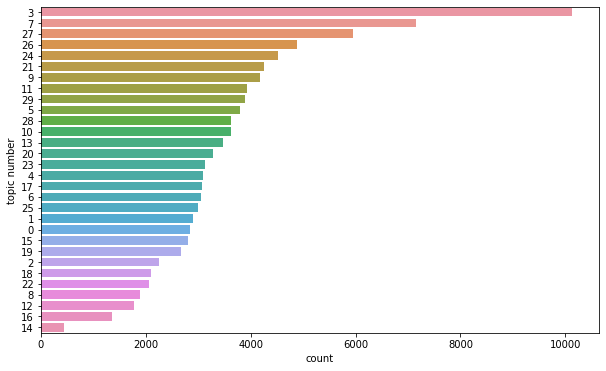

In [23]:
nlp.plot_document_topic_distribution()

In [24]:
with open("b_collection_extracted/mallet_model_30_topics", "wb") as f:
    nlp.lda_model.save(f)

In [25]:
model = malletmodel2ldamodel(nlp.lda_model)
panel = pyLDAvis.gensim.prepare(model, nlp.bag_of_words, nlp.id2word)
with open("b_collection_extracted/pyldavis30tops.html", "w") as f:
    pyLDAvis.save_html(data=panel, fileobj=f)
display(HTML(filename="b_collection_extracted/pyldavis30tops.html"))

/home/hengelhardt/masterarbeit/.venv/lib/python3.6/site-packages/pyLDAvis/_prepare.py:223: RuntimeWarning: divide by zero encountered in log
  kernel = (topic_given_term * np.log((topic_given_term.T / topic_proportion).T))
/home/hengelhardt/masterarbeit/.venv/lib/python3.6/site-packages/pyLDAvis/_prepare.py:240: RuntimeWarning: divide by zero encountered in log
  log_lift = np.log(topic_term_dists / term_proportion)
/home/hengelhardt/masterarbeit/.venv/lib/python3.6/site-packages/pyLDAvis/_prepare.py:241: RuntimeWarning: divide by zero encountered in log
  log_ttd = np.log(topic_term_dists)


In [50]:
result_df = pd.read_pickle("b_collection_extracted/document_result_df_25tops")
stat_df_joined = stat_df[filter_on_stats(stat_df)].join(result_df.dominant_topic, on='thread_id')

In [52]:
pd.set_option('display.max_rows', 500)

In [98]:
topic_map = {}

In [60]:
# Pädothreads, viel Bildertausch
stat_df_joined[stat_df_joined.dominant_topic == 0].head(200) 

thread_id board                                       semantic_url  \
10     828635931     b                                    new-loli-thread   
16     828822496     b    donald-j-trump-is-a-registered-sex-offender-why   
31     831859941     b   how-do-i-tell-a-girl-i-like-that-i-have-a-fetish   
181    824345236     b  itt-post-rule-34-hentai-pics-that-make-you-cum-in   
220    826584410     b  i-was-bored-during-quarantine-so-i-went-on-omegle   
246    826113226     b                                      hentai-thread   
309    825258819     b                                            ghosted   
732    824966935     b  if-you-could-keep-a-girl-in-your-basement-and-get   
809    831503060     b                                    ow-my-childhood   
812    824380414     b     to-any-white-anons-that-watch-interracial-porn   
823    829930615     b  i-dont-want-to-be-at-my-boyfriends-home-because-i   
962    823699204     b                                      cg-loli-shota   
1017   829481462     b                   loli-thread-burn-faggots-edition   
1191   830377201     b   why-are-lolis-so-hot-why-are-lolis-so-cute-which   
1200   822802970     b                                             cubfur   
1295   831587820     b                      essential-diaper-thread-edt-1   
1466   828383498     b    what-happened-to-the-dude-who-was-obsessed-with   
1579   831351503     b                                 diaper-thread-cont   
1690   825151628     b    does-incest-porn-actually-exist-on-the-internet   
1773   823237322     b                 diaper-thread-will-post-for-awhile   
1777   826853919     b  im-sick-of-all-of-you-faggots-you-fucking-disgust   
1973   822814480     b                            has-canada-lost-its-way   
2013   827686862     b     if-you-knew-you-would-100-not-get-caught-would   
2171   823990932     b                                   diaperboy-thread   
2287   826903966     b     if-a-father-rapes-his-boy-son-is-it-rape-kinda   
2320   831905391     b                              who-even-is-this-girl   
2366   828280928     b     whats-the-worst-porn-fetish-and-why-is-it-scat   
2460   831321806     b                                     its-shota-time   
2475   830376747     b                          heterosexual-shota-thread   
2577   831307670     b                                  why-did-she-do-it   
2704   829582492     b   i-have-a-problem-need-based-advice-cuck-wants-me   
2747   830162242     b        hypermuscular-lolis-only-no-futas-lolis-are   
2810   831834874     b                                               loli   
2871   824666813     b             loli-thread-marathon-lolithon-2020-184   
2959   829691306     b    new-loli-thread-everyone-post-cute-loli-cunnies   
3150   830663201     b                                          gay-shota   
3160   824409662     b                     women-you-want-to-see-bleached   
3439   830405879     b                                    shota-no-limits   
3444   829814423     b                                 way-too-big-thread   
3471   825837670     b                          whats-so-wrong-about-this   
3538   831002936     b                                            why-not   
3552   826868681     b   is-it-immoral-and-wrong-to-find-this-12-year-old   
3572   823733771     b             loli-thread-marathon-lolithon-2020-111   
3575   827256477     b    is-it-true-you-can-determine-a-girls-age-by-the   
3859   824758001     b             loli-thread-marathon-lolithon-2020-190   
3920   831739203     b                                loli-thread-lets-go   
4051   830789214     b                                                      
4058   830757344     b                                      diaper-thread   
4091   829893426     b                   guess-what-ive-been-charged-with   
4156   828575655     b   women-cannot-rape-men-in-the-sense-that-the-mans   
4170   826386896     b                                      diaper-thread   
428

In [102]:
topic_map[0] = "bildertausch"

In [61]:
#Freizeit (Musik, Spiele, Videos)
stat_df_joined[stat_df_joined.dominant_topic == 1].head(200)

thread_id board                                       semantic_url  \
73     822802776     b  what-video-game-do-you-play-when-you-have-nothing   
104    823028499     b                  why-did-liberals-ruin-the-witcher   
209    830968634     b         ive-just-discovered-that-i-dont-like-to-do   
317    828321157     b         is-there-anything-worthwhile-on-this-thing   
385    824976536     b                                      2-years-today   
435    830011759     b                                   post-weird-stuff   
440    822933274     b      itt-list-3-of-your-favorite-music-artists-and   
445    824541081     b  hey-is-this-series-worth-a-fiddlers-fuck-whatever   
486    826146110     b                                                itt   
490    828416108     b  hey-guys-im-streaming-until-i-hit-platinum-im-not   
505    823034534     b                                 nsfw-gaming-thread   
511    828004143     b    jre-moving-exclusively-to-spotify-by-the-end-of   
556    822823389     b                                post-your-commander   
594    829812748     b                                             thread   
683    826638604     b      guys-should-i-replay-morrowind-or-skyrim-dubs   
735    830635564     b                                 what-could-this-be   
1015   830880952     b  why-hasnt-ghost-thunderdomed-ardhamon-and-jackler   
1121   825214662     b    hey-guys-can-you-keep-an-eye-on-my-scp173-for-a   
1124   827336828     b     up-and-coming-rapper-check-out-my-new-song-and   
1177   831612791     b    i-was-listening-to-the-fairly-odd-parents-intro   
1277   829204558     b    rescue-the-princess-with-your-vidya-knowledge-v   
1280   829234763     b   who-wants-to-be-in-my-epic-dinosaur-movie-theres   
1435   826789005     b                          anyone-here-read-japanese   
1470   824056746     b                            why-are-you-mad-today-b   
1738   825612160     b    trips-get-to-pick-what-game-i-play-for-my-first   
1878   828889015     b    will-the-ps5-be-more-powerful-then-the-new-xbox   
1937   827743485     b        friend-doesnt-like-metal-or-rock-in-general   
1978   828954123     b             itt-b-writes-a-song-one-word-at-a-time   
2130   822711081     b                                jamie-bell-birthday   
2140   831149004     b    i-am-haunted-by-the-eerie-gaze-of-eric-bogosian   
2143   823201637     b  post-a-game-others-say-if-they-love-it-or-hate-it   
2167   830846694     b    why-are-skeletons-always-villains-in-vidya-game   
2494   830803593     b                                    selfie2animecom   
2504   823004961     b                             i-played-undertale-ama   
2521   829376557     b                     which-porno-has-the-best-story   
2644   828277895     b                                    only-good-music   
2731   831745072     b                                   anon-i-made-this   
2743   829187483     b        this-is-how-africa-would-look-today-if-only   
2753   824154010     b      please-help-me-to-name-my-fps-game-similar-to   
2794   830421531     b                                anyone-remember-him   
2802   829107443     b                              loli-game-suggestions   
2815   828927257     b                      whats-your-favourite-dinasour   
2960   827978635     b     what-is-your-opinion-of-the-promised-neverland   
2985   827396637     b   tell-me-about-something-unimportant-which-really   
3035   826597524     b       which-animated-character-do-you-want-to-fuck   
3098   826030074     b                                 nsfw-gaming-thread   
3354   829322206     b                            im-completely-blind-ama   
3472   826460629     b     do-you-get-to-the-cloud-district-very-often-oh   
3618   824130374     b                                    post-irl-bosses   
3674   827620215     b     so-im-looking-for-some-shit-to-read-anyone-got   
3677   827178197     b                 2001-was-the-best-year-of-all-time   
369

In [100]:
topic_map[1] = "freizeit"

In [62]:
#viel Kik und Tributes
stat_df_joined[stat_df_joined.dominant_topic == 2].head(200)

thread_id board                                       semantic_url  \
77     828649156     b                                       wickr-thread   
85     826299717     b   photoshop-thread-post-girls-that-you-want-to-see   
135    825663129     b                                         kik-thread   
142    827022014     b       i-make-porn-addiction-and-cuckquean-captions   
272    829538535     b     lets-get-a-dirty-kik-thread-going-post-asl-and   
384    823311967     b    can-we-get-some-tributes-for-this-bitch-her-kik   
409    829607653     b  snapchat-share-thread-gf-ex-friend-fwb-trades-the   
701    825917240     b                                           thoughts   
703    829807862     b                        skinny-emoaltgothpunk-girls   
708    825079455     b                     expose-your-girls-assholepussy   
752    826378154     b                            for-this-anon-826377342   
774    824603990     b                                          want-more   
783    826657334     b                                        trib-thread   
791    831649276     b           how-far-would-a-cuck-go-to-make-the-bull   
829    823008209     b                             tribute-sharing-thread   
830    827048393     b      rutgers-camden-thread-share-any-wins-or-girls   
936    830390261     b    you-know-you-have-your-doubts-let-me-check-your   
964    830060638     b                                cock-tribute-thread   
1010   825964571     b                                cocktributes-anyone   
1141   822746406     b          can-someone-cum-tribute-or-cock-this-girl   
1150   831353508     b         cum-tributes-are-art-cum-tributes-are-love   
1228   824112540     b               who-owns-my-slut-wifes-full-exposure   
1390   823506493     b                                        snap-thread   
1486   830489082     b                                    female-butthole   
1597   831450744     b                                           new-trib   
1626   830392835     b           tiernan-thread-who-subscribes-drop-goods   
1641   830849505     b                                          feet-face   
1679   831351796     b                                     new-kik-thread   
1821   826993299     b    cuck-is-sharing-his-wife-with-me-wanna-see-more   
1825   823197835     b         cali-is-shut-down-well-kinda-so-kik-thread   
1887   826322464     b         sending-paki-girls-for-big-white-cocks-kik   
1918   822741252     b                                               hi-b   
1920   828163953     b                                      tribute-bread   
2026   825410106     b                                       cock-tribute   
2048   831103950     b                                           thoughts   
2083   826014339     b     new-trib-thread-post-how-you-know-them-edition   
2177   831492865     b                                     new-kik-thread   
2215   830059075     b                                     4chan-kik-chat   
2228   827575975     b                                                kik   
2402   828330099     b                            cum-tributes-are-art-ii   
2500   824418169     b                       shouldnt-sharesavedwant-more   
2558   825294523     b       kik-thread-cucks-hit-me-up-will-rate-your-gf   
2629   825742386     b                             sissytrapfemboy-thread   
2890   827178797     b                                 thoughts-on-asians   
2897   826875682     b                    alright-cucks-roll-dubs-send-to   
2899   826211650     b                                     teacher-thread   
3047   828484003     b                            pics-you-shouldnt-share   
3196   824388835     b                                           trib-new   
3304   827885194     b                           post-a-cum-tribute-to-me   
3360   829765299     b                      cousin-sarah-chicago-thoughts   
3515   829049900     b                           boy-butt-ratewwyd-thread   
355

In [103]:
topic_map[2] = "trib_kik"

In [63]:
#ylyl, rekt, 
stat_df_joined[stat_df_joined.dominant_topic == 3].head(200)

thread_id board                                       semantic_url  \
13     828629011     b                         creepshothidden-cam-thread   
79     824398296     b                                        remember-me   
125    830869045     b                first-three-words-that-come-to-mind   
164    829962729     b                             dick-comparison-on-kik   
230    830533983     b  since-its-fathers-daylets-post-women-whos-fathers   
236    823486733     b                                   you-fap-you-lose   
458    824291847     b        i-just-blew-my-nut-on-your-bitches-butt-bro   
757    825963504     b                  itt-we-post-actors-who-look-alike   
800    830165210     b   my-friend-has-never-heard-of-4chan-show-him-what   
965    825101299     b          fuck-it-new-ylyl-old-one-is-getting-stale   
1012   826789388     b                                           shrekism   
1037   824176698     b                                       poz-me-daddy   
1061   824944460     b                                               ylyl   
1103   824239748     b                      look-at-this-cat-dancing-lmao   
1106   828368086     b          ylyl-cursed-edition-in-celebration-of-the   
1179   829110193     b                                   age-cunts-fucked   
1384   827447653     b   guys-my-mom-has-stumbled-upon-4chan-via-my-phone   
1445   826677213     b                               no-ylyl-get-involved   
1517   824370554     b      they-will-bring-the-end-to-us-share-this-with   
1695   828342317     b                                         faces-of-b   
1838   829674441     b                                count-to-10-faggots   
1941   830033179     b                   see-something-you-like-white-boy   
2018   825441170     b                                           new-ylyl   
2318   824612949     b                      how-does-this-make-you-feel-b   
2344   827233690     b      new-to-4chan-give-me-the-proper-4chan-welcome   
2347   830312826     b  how-do-you-get-rid-of-an-obsessive-cunt-that-wont   
2422   828420605     b                            ylyl-heat-coin-addition   
2487   824422969     b  first-words-that-come-to-your-mind-or-your-mother   
2520   827112109     b                 coppercab-says-he-will-fk-4chan-up   
2632   823828603     b      can-someone-post-some-of-these-chinese-animal   
2710   825262031     b                                           sad-rekt   
2858   823319204     b                                 yolo-ylyl-you-lose   
2981   831707085     b                                        pic-related   
3067   823458724     b                   why-the-fuck-is-my-dick-so-small   
3269   825308247     b   my-brown-spic-mexican-wife-is-a-total-white-cock   
3328   829109789     b                   read-it-like-the-spiderman-theme   
3346   824466838     b                                        gore-thread   
3362   830850172     b                                     u-laugh-u-lose   
3425   825219554     b                                                  f   
3498   831174638     b                                          tfw-no-bf   
3499   828924290     b                                        rekt-thread   
3610   825689027     b                              whats-up-bros-im-back   
3738   822922982     b                               ylyl-unfunny-edition   
3751   826522019     b           wonchoochochiweeeaaaahhhaaaaaaaaaaa-aaaa   
3870   830327073     b                     wtf-getting-tired-of-this-shit   
3925   827409997     b                         say-im-a-nigger-to-my-face   
3943   823332313     b         your-girlfriend-would-rather-fuck-this-guy   
3999   830169969     b                                               test   
4041   824031485     b                                  ylyl-dont-ruin-it   
4161   824465750     b                                               ylyl   
4436   823052868     b        post-the-last-image-that-you-saved-from-the   
446

In [104]:
topic_map[3] = "ylyl_rekt"

In [64]:
# social (Bildertausch)
stat_df_joined[stat_df_joined.dominant_topic == 4].head(200)

thread_id board                                       semantic_url  \
33    827517563     b                                  titty-rate-thread   
103   831922126     b                                              booty   
115   825888156     b                                social-fap-thread-4   
116   830151638     b                                   is-my-cousin-hot   
122   829907503     b                                       big-naturals   
133   831068751     b                                         social-fap   
155   826597428     b   unsauceables-thread-testing-the-might-of-b-girls   
200   829592543     b                                         social-vil   
244   827712844     b                                      more-chubbies   
280   825761668     b                                         social-fap   
326   827842439     b                                 sociala-no-1897536   
419   827500096     b                shouldnt-sharesavedwant-more-thread   
436   826777043     b                first-three-words-that-come-to-mind   
488   826866987     b             here-for-your-viewing-pleasure-for-now   
489   829461362     b                               blowjobs-lets-see-em   
520   825712282     b                            chubbythickcurvy-thread   
555   831809355     b    german-girls-only-you-want-to-see-demolished-by   
700   825553257     b                          yellow-fever-asian-thread   
730   824382567     b                                               fbig   
760   824640615     b                             girl-scouts-in-bikinis   
764   823976220     b                                           social-x   
779   825026744     b                               socials-fap-thread-2   
844   824175840     b                                           social-x   
849   825727648     b                            social-media-fap-thread   
862   822797478     b                             ontario-recognize-time   
891   829947627     b         what-kind-of-porn-does-my-gf-look-like-she   
905   830459170     b                       this-here-is-the-milf-thread   
955   827776369     b                                    social-fap-6002   
972   824289796     b         who-has-more-ive-been-told-there-are-nudes   
994   829002879     b                                      fb-social-iii   
1025  826083330     b                      nother-new-socials-fap-thread   
1041  826181234     b                            pics-you-shouldnt-share   
1086  827626333     b                                     slampig-thread   
1092  827655819     b                                     rate-this-girl   
1096  828975964     b                               new-social-media-fap   
1117  829271947     b                                        fb-ig-again   
1122  831771753     b                          would-you-fuck-this-chick   
1132  825266364     b                                 asian-girls-thread   
1185  827969167     b                                    tit-rate-thread   
1199  825241454     b                                        chubbythicc   
1220  827860754     b                     amateur-boudoirlingerie-thread   
1298  824294873     b                            everyone-say-hi-to-abby   
1312  828660522     b     i-love-it-when-they-wear-their-fucktoy-outfits   
1318  825614485     b                                      social-thread   
1319  829361468     b                                    michigan-thread   
1327  830141355     b       anyone-else-have-a-thing-for-perky-tits-with   
1336  827537670     b                               post-tits-like-these   
1365  827583409     b          is-my-mom-going-through-a-mid-life-crisis   
1399  826276933     b                            gfwife-tits-rate-thread   
1405  827496343     b                                         new-social   
1426  825263612     b               what-do-u-think-of-her-my-girlfriend   
1449  830475622     b                                 

In [105]:
topic_map[4] = "bildertausch"

In [65]:
#rassimus => PoC
stat_df_joined[stat_df_joined.dominant_topic == 5].head(200)

thread_id board                                       semantic_url  \
18     829666562     b                                    be-me-brown-guy   
98     829802307     b                                is-this-okay-to-say   
228    829176998     b     first-i-destroy-this-pussy-then-i-destroy-your   
255    828864604     b                           its-over-america-is-ours   
293    830654398     b   if-i-say-all-lives-matter-im-a-racist-if-i-stand   
319    825387066     b                          do-you-really-hate-blacks   
322    829662217     b                                     guess-my-crime   
347    829473584     b                     nigger-spear-pelters-listen-up   
395    829012139     b                  4chan-supports-black-lives-matter   
430    830870664     b                          black-lives-matter-thread   
451    830464450     b    violent-felon-dies-while-being-arrested-for-yet   
468    831861513     b   black-lives-matter-is-not-a-peaceful-protest-its   
491    829104640     b      this-whole-shitshow-has-just-confirmed-for-me   
561    829092871     b  did-anyone-ever-find-her-instagram-shes-so-cute-i   
566    822998997     b      the-lori-vallow-case-continues-to-become-more   
604    828434799     b                 blackebonydarkynegress-thread-cont   
623    830625707     b  you-come-back-fresh-from-the-trump-rally-with-20k   
671    830743457     b                                                      
725    825579420     b                                          apologlze   
740    823914294     b      you-may-pull-a-million-stats-out-of-your-butt   
748    828750905     b                                            justice   
765    829703563     b      if-you-are-a-white-person-dont-associate-with   
782    829817733     b                                      is-this-facts   
842    829455757     b  if-white-privilege-is-real-thingand-it-is-putting   
967    829870501     b   bullet-holes-from-the-shootout-in-my-parking-lot   
1056   829063740     b   a-video-of-the-police-smashing-up-the-front-of-a   
1137   828739590     b                       race-war-2020-betting-thread   
1267   827050304     b       why-is-it-so-easy-for-black-guys-to-get-1010   
1275   829164692     b                                 black-lives-matter   
1362   828760762     b                                        just-saying   
1422   828812934     b  hey-libshits-you-did-it-you-threw-a-hissy-fit-and   
1439   830159791     b                                       we-havin-fun   
1487   830415921     b                       what-is-it-they-want-exactly   
1551   829566301     b     black-protestor-that-was-shot-is-getting-a-big   
1692   826065950     b   the-average-black-man-dick-is-eight-inches-while   
1724   831252656     b                 why-are-americans-such-psychopaths   
1730   830218721     b                                  what-do-you-think   
1731   831723529     b        why-is-half-of-b-blacked-and-the-other-half   
1764   829557822     b       black-14-year-old-executed-because-of-murder   
1916   826021828     b    how-do-yall-crackers-feel-about-me-banging-this   
1957   829752022     b    to-the-anons-that-like-watching-interracialbmwf   
1991   831130911     b      white-people-you-seriously-honestly-dont-feel   
2134   830123334     b                                  hey-b-rename-chaz   
2206   828896164     b                           george-floyd-meme-thread   
2266   827954477     b   awwww-white-people-cant-say-nigger-without-being   
2455   823592393     b  why-havent-you-surrendered-your-seed-to-the-black   
2543   830806949     b                                 can-b-explain-this   
2655   830948023     b                okay-black-people-lets-be-real-here   
2736   826114424     b   why-are-sooo-many-black-women-getting-knocked-up   
2772   824169858     b                                 bbc-general-thread   
2777   831825761     b                               is-blackfacing-funny   
281

In [106]:
topic_map[5] = "rassismus"

In [66]:
#Lebenslagen/Ratschläge/Fragen/Rekt
stat_df_joined[stat_df_joined.dominant_topic == 6].head(200)

thread_id board                                       semantic_url  \
64     829026509     b  on-my-way-to-the-hood-tonight-thinking-of-running   
544    829489499     b                               she-entered-my-house   
641    825473723     b                                    rektgore-thread   
648    830836530     b      im-probably-getting-kicked-out-of-the-marines   
659    825623851     b   posting-here-because-i-really-dont-have-anywhere   
749    828355690     b                                 why-no-rekt-thread   
786    831237829     b   pictures-of-people-in-the-er-pictures-of-medical   
977    831878264     b             who-is-the-hottest-killer-of-all-times   
1059   828589532     b                                                      
1208   829125657     b                                          62-197lbs   
1273   825898184     b                what-do-you-look-at-in-this-picture   
1303   828935462     b                             need-revenge-help-bros   
1483   829753289     b        how-could-i-cut-one-of-my-fingers-off-while   
1651   824731053     b      im-fucking-done-bois-can-anyone-recommend-the   
1964   825936056     b         you-walk-in-your-room-and-see-this-what-do   
2034   824862659     b                            attention-all-engineers   
2249   825685663     b   how-does-it-feel-knowing-i-could-crush-your-head   
2339   824553556     b      how-to-get-brick-or-rock-through-a-businesses   
2437   825520618     b                  i-want-to-know-how-much-they-cost   
2652   831730064     b                                  helicopter-thread   
2666   828084001     b                     would-you-fuck-a-black-women-b   
2702   826859065     b         hey-b-i-have-some-issues-that-are-actually   
2879   826843124     b    you-and-your-african-american-friends-stand-out   
3053   831589015     b      how-would-you-kill-yourself-no-meme-answers-i   
3170   825239346     b          i-want-to-kill-myself-but-i-want-it-to-be   
3225   824422544     b      can-we-finally-take-their-rifles-out-of-their   
3229   824616455     b            in-this-thread-only-retarded-egirls-pls   
3313   824776693     b                                     where-is-she-b   
3600   830247439     b     does-anyone-have-a-siamese-cat-thoughts-on-the   
3758   827918113     b                                        hello-anons   
3772   826366149     b                                a-walk-in-the-woods   
3788   824526573     b   i-have-confuse-why-englishmen-drive-on-the-wrong   
3803   827180649     b  post-a-picture-of-something-that-would-defeat-the   
3804   831506803     b     why-do-you-get-so-angry-when-driving-literally   
3816   830650802     b                      you-come-across-a-creepy-hole   
3922   827114664     b                 suvs-are-niggercars-prove-me-wrong   
3944   824983807     b     im-at-the-shops-you-need-anything-dubs-decided   
3954   827990869     b                    what-do-you-want-to-do-with-him   
3975   827922766     b     i-bought-a-soundbar-with-subwoofer-pic-related   
4179   824414034     b   im-putting-a-team-together-to-take-down-drumpfff   
4320   831548538     b                who-wins-the-us-marines-or-the-ants   
4388   827079210     b                             what-the-hell-happened   
4434   826760295     b   why-havent-you-taken-up-running-you-would-better   
4663   830430841     b                                             bee-me   
4718   824082259     b                              cute-creatures-thread   
4732   830701028     b   turns-out-the-rope-in-his-garage-was-just-a-pull   
4817   831328823     b                                    be-nursing-home   
4828   831765460     b                  anons-how-would-you-stop-bullying   
4860   825901549     b                 4chan-will-argue-about-anything-so   
4890   829800170     b                              beastie-thread-anyone   
4950   824224044     b      b-writes-a-green-text-story-one-sentence-at-a   
496

In [107]:
topic_map[6] = "lebenslagen_ratschläge"

In [67]:
#inzest/familie
stat_df_joined[stat_df_joined.dominant_topic == 7].head(200)

thread_id board                                       semantic_url  \
132    825543132     b                  tell-me-what-kind-of-perv-you-are   
187    823014636     b     would-you-really-be-surprised-if-you-found-out   
218    823723457     b                      girls-that-swallowed-your-cum   
368    828749364     b                            welp-this-just-happened   
410    825088782     b                                              on-ft   
545    823336452     b                                 mother-or-daughter   
746    827624102     b      is-it-wrong-that-i-want-to-see-my-cousin-nude   
797    824651434     b   greentext-thread-story-time-anything-sexy-incest   
1215   826732918     b    anyone-else-molested-as-a-kid-but-actually-have   
1349   828088085     b   be-honest-when-was-the-first-time-you-jerked-off   
1744   828491961     b   so-my-moms-faggot-bf-keeps-coming-on-to-me-after   
1805   825893271     b                             who-the-fuck-is-this-b   
1812   830820321     b           i-just-raped-a-woman-in-the-restroom-bar   
1975   827790359     b                  does-anyone-know-you-browse-4chan   
1998   825788789     b    ive-been-licking-my-sisters-panties-clean-since   
2173   826633252     b      what-are-some-fucked-up-sexual-things-you-did   
2184   824797041     b       my-girlfriend-farts-in-my-mouth-on-a-regular   
2265   824131595     b   has-b-ever-gotten-a-girl-pregnant-without-having   
2401   825028272     b    putting-condom-on-a-cock-all-set-to-go-ready-to   
2456   823952659     b      sister-left-herself-logged-into-twitter-on-my   
2535   823857229     b      hey-chads-what-is-the-most-sexually-degrading   
2597   823030785     b  im-curently-sitting-in-the-minneapolis-saint-paul   
2742   823186377     b                                 weirder-the-better   
2845   823201358     b     think-my-aunt-or-cousin-would-be-a-better-fuck   
2886   828304499     b                           did-he-deserve-it-though   
2955   827826478     b   the-wide-acceptance-of-wearing-a-thong-in-public   
3064   830902502     b     whats-the-absolute-worst-thing-youve-ever-done   
3242   831019499     b             whats-the-gayest-thing-youve-ever-done   
3306   830252349     b                                              alert   
3383   830529502     b   sup-b-heres-a-little-story-of-what-just-happened   
3390   824722548     b                     i-fucked-my-14-year-old-sister   
3647   822707734     b                          blondes-are-built-for-bbc   
3771   824270204     b       incest-thread-starting-with-my-little-sister   
4077   824158866     b                                 you-know-the-drill   
4086   829211136     b                                ops-daughter-thread   
4137   827210141     b     share-your-secrets-anon-let-it-all-out-give-us   
4177   825890034     b   you-guys-ever-fuck-a-girl-senseless-like-a-fb-or   
4381   831536104     b    so-b-i-had-a-really-fucked-up-day-the-other-day   
4730   831025062     b                            stolen-pics-thread-pt-2   
4905   829187934     b                                      enter-bedroom   
5006   828988476     b  for-some-reason-i-just-want-chaos-now-i-only-want   
5014   830880211     b  anyone-have-any-hooker-stories-from-sullivant-ave   
5047   822881370     b                                  creephiddenvoyeur   
5068   827831477     b     guy-this-fucking-baby-is-going-to-ruin-my-life   
5075   827075000     b                           my-stupid-fucking-sister   
5165   828904603     b                                          homealone   
5278   828560765     b                                       hot-teachers   
5340   822942326     b    my-gf-flashing-in-a-hotel-corridor-does-anybody   
5538   823518100     b                                      incest-thread   
5594   831641715     b                  how-does-b-feel-about-the-duggies   
5621   825469490     b        after-8-years-of-lurking-i-need-your-help-b   
564

In [108]:
topic_map[7] = "inzest_familie"

In [68]:
#Rassismus
stat_df_joined[stat_df_joined.dominant_topic == 8].head(200)

thread_id board                                       semantic_url  \
11     828806746     b                                apologize-white-goy   
299    822885980     b     why-does-everybody-on-4chan-keep-saying-faggot   
496    823975719     b     ok-so-hypothetically-if-you-were-dating-a-cute   
554    826417099     b  why-is-it-that-people-make-a-commitment-as-big-as   
573    824008662     b                                     hangman-thread   
848    827691019     b                   hey-friends-i-like-to-make-memes   
973    824395528     b  considering-the-fact-that-this-is-the-norm-how-do   
1170   824123260     b                 why-does-this-gif-scare-me-so-much   
1245   825424679     b          i-just-had-a-massive-shit-it-was-the-best   
1454   827680021     b    this-board-unironically-gets-worse-every-single   
1703   830885165     b                                           1r5w4qfc   
1717   828835449     b    why-do-you-guys-hate-transgender-people-so-much   
1853   831510307     b                    twatter-niggers-are-doxing-kids   
1947   831669511     b         woke-far-left-democrat-twitter-says-the-97   
2095   823274820     b                   girls-that-deserve-to-be-blacked   
2113   830358172     b                                           thoughts   
2226   824351036     b                             reddit-is-literal-shit   
2235   825229425     b   ok-so-this-is-disgusting-and-pathetic-but-i-need   
2312   830448640     b                                            wake-up   
2501   828578656     b       is-it-just-me-or-is-b-right-now-being-at-its   
2544   824081423     b                        fucking-jews-pieces-of-shit   
2551   823534527     b      trannies-are-good-people-fight-the-good-fight   
2637   826591712     b       roll-dubs-send-this-pic-to-your-gfwifefemale   
2749   829139979     b      would-she-have-done-this-if-he-was-attractive   
2804   828349425     b  why-is-there-so-many-cucklord-degenerates-on-this   
2945   831395239     b                            my-pepe-bros-it-is-time   
3158   831147928     b       has-there-ever-been-a-bigger-fall-from-grace   
3274   826203699     b                       most-offensive-joke-you-know   
3330   827870578     b                                               well   
3388   827866664     b  oohhhhh-yes-cum-inside-white-boy-put-a-baby-in-me   
3455   827584421     b         this-girl-i-used-to-love-went-from-generic   
3581   826697111     b               get-in-here-fags-we-are-under-attack   
3858   830710129     b      america-is-literally-the-worst-place-in-human   
3883   823617316     b  girls-that-should-be-getting-bbc-gangbanged-daily   
4009   831050740     b                           ill-just-leave-this-here   
4098   827609952     b    feminazis-are-attacking-the-symbol-of-hope-come   
4151   828601745     b                                             retard   
4233   830859355     b                               tranz-support-thread   
4243   830891627     b                               what-happened-to-men   
4304   827704903     b                            thoughts-on-pic-related   
4367   824589295     b                      how-does-this-timeline-feel-2   
4508   825765487     b               alles-gute-zum-geburtstag-mein-fhrer   
4558   829420511     b                           ill-just-leave-this-here   
4575   827717893     b    got-bullied-at-work-on-friday-my-coworkers-said   
4625   825264067     b    this-bitch-is-so-racist-it-makes-me-sick-can-we   
4777   827857649     b                                          sieg-heil   
4907   828230048     b              which-pronoun-should-we-call-him-with   
4910   826215273     b     breaking-my-100-day-no-fap-today-i-promised-it   
5043   831356474     b     hey-b-i-have-come-to-ask-for-youre-help-with-a   
5232   825951022     b    last-week-i-had-sex-with-my-jewish-wife-for-the   
5234   828735967     b                                no-trolling-edition   
531

In [109]:
topic_map[8] = "rassismus"

In [69]:
# viel anal, teils tranny, wwyd
stat_df_joined[stat_df_joined.dominant_topic == 9].head(200)

thread_id board                                       semantic_url  \
140    827987777     b        post-pics-of-girls-exposing-their-brown-eye   
158    825475169     b    how-do-you-prevent-a-girl-from-biting-your-cock   
223    829726715     b      sissy-cd-here-havent-dressed-up-in-awhile-and   
269    824808262     b     whats-the-biggest-dick-your-girl-has-ever-been   
279    827746969     b                                  is-she-attractive   
349    829658349     b   anyone-here-ever-had-a-prostate-orgasm-why-whats   
466    826323263     b                             girls-to-cum-on-thread   
502    824781398     b                      would-you-let-me-fuck-your-gf   
577    830037382     b                            wwyd-anal-abuse-edition   
910    829154958     b                which-would-you-rather-fuck-and-why   
913    823357610     b                                would-you-fuck-me-b   
1031   831521953     b        first-three-words-that-come-to-mind-or-your   
1222   825166419     b     im-gonna-post-myself-cumming-on-some-figurines   
1270   827056916     b                    count-to-3-to-get-the-whole-pic   
1482   824034838     b                             girls-for-bbc-breeding   
1594   831130167     b     id-love-sabrina-to-piss-straight-into-my-mouth   
1718   825842648     b                  friends-you-want-to-see-blacked-2   
1722   828733336     b                             i-need-to-be-colonized   
1919   831304474     b   im-going-through-a-brown-girl-phase-woke-up-this   
1984   828250786     b                                     hello-everyone   
2076   829788711     b            what-are-the-best-condoms-in-bs-opinion   
2082   824503448     b                teens-you-want-to-watch-get-blacked   
2144   827085518     b      roughest-thing-youd-do-to-a-19-year-old-twink   
2199   826834285     b                                 girls-who-need-bbc   
2204   825342577     b  webm-related-why-was-i-born-skinny-but-with-a-big   
2264   831091894     b        just-ordered-this-sex-doll-what-am-i-in-for   
2354   823082189     b                                            sub-guy   
2552   826882162     b                               she-makes-my-pp-hard   
2657   831795915     b                               wwyd-no-holds-barred   
2728   825242203     b                  im-gay-and-im-attracted-to-myself   
2914   830207944     b  i-want-to-joust-cocks-over-my-wifes-face-and-make   
2964   828593141     b       ive-been-a-bad-boy-that-cums-too-much-so-ive   
3000   829024080     b    wwyd-to-a-bitchy-horse-girl-if-she-was-alone-in   
3088   829908484     b                                 rate-de-bussi-boss   
3122   830551074     b    how-would-you-design-perfect-sex-torture-device   
3323   823570987     b                         cock-rate-thread-ill-start   
3394   822748279     b        i-love-having-my-nipples-licked-and-pinched   
3416   830406802     b                               would-you-fuck-my-ex   
3421   822815486     b              the-ok-boomer-girl-is-fucking-stacked   
3430   829518503     b                                       which-hole-b   
3540   826792583     b             wwyd-be-brutal-replies-get-more-of-her   
3620   829797252     b        should-white-dicklets-be-expelled-from-porn   
3686   827222275     b                       you-know-the-drill-white-boi   
3845   825008928     b                             rate-my-skills-and-ama   
3852   827583158     b                               implying-you-wouldnt   
3996   825480766     b    tell-me-how-you-would-use-and-abuse-this-slag-i   
4087   827205650     b                          would-you-fuck-this-chick   
4104   825080358     b   what-are-some-sex-toys-i-can-make-with-household   
4127   823362113     b     ask-a-sissy-whos-been-stuck-in-quarantine-with   
4302   827212453     b  i-want-to-suck-every-guys-cock-here-i-want-you-to   
4383   829982387     b               well-were-consequences-ever-the-same   
442

In [110]:
topic_map[9] = "anal_trans_wwyd"

In [70]:
# roll
stat_df_joined[stat_df_joined.dominant_topic == 10].head(200)

thread_id board                                       semantic_url  \
22     823179846     b                     anybody-know-this-girl-curious   
50     825627752     b                                               roll   
113    827344923     b    trips-decides-the-name-and-number-i-get-on-this   
118    825707671     b                                            welcome   
283    829570289     b                first-three-words-that-come-to-mind   
306    828763604     b   quads-and-ill-shove-one-of-these-into-my-urethra   
388    828703063     b                                               roll   
463    829051701     b  last-digit-of-every-reply-that-many-punches-to-my   
533    827644551     b                                 social-risk-thread   
588    827335168     b                                           im-bored   
598    830648826     b   regrettably-my-girlfriend-passed-away-because-of   
652    825235791     b                                           singes-1   
664    831320614     b     if-b-can-count-to-5-in-consecutive-replies-ill   
715    826514827     b                                       roll-em-boys   
802    826171801     b   pick-an-asian-say-what-youd-do-and-ill-post-more   
872    823079095     b     alright-phaggets-this-is-the-definitive-thread   
880    826371258     b  trips-decide-what-i-set-my-steam-username-and-pic   
1034   824192246     b                                     roll-for-waifu   
1073   825652965     b   dubs-decide-what-porn-i-jerk-it-to-must-be-legal   
1087   828182509     b             its-time-again-b-trips-kill-themselves   
1116   825982818     b                 retrofrag-needs-a-fap-whos-joining   
1158   826154868     b                          no-good-gets-thread-yikes   
1196   825701986     b                  how-often-do-you-think-about-dubs   
1311   825381974     b                            social-risk-thread-cont   
1565   831026601     b           nude-game-thread-lets-get-one-going-boys   
1602   826250983     b                          trips-and-i-show-pussy-xd   
1789   822824786     b                                          game-time   
1827   823911907     b             dubs-get-to-see-me-swallow-my-own-load   
1854   827052649     b                 how-much-would-you-pay-to-fuck-her   
2063   828888489     b                            mega-numbers-are-coming   
2078   826957886     b                                           its-time   
2148   826885101     b                                           odds-fap   
2205   830517754     b                                   execution-thread   
2527   824154429     b                                          game-time   
2642   825368812     b                         dubs-decides-get-me-laid-b   
2721   831864017     b                                        evens-sleep   
2730   825889820     b   alexa-thread-dubs-for-rare-trips-for-nudes-quads   
2741   826296633     b                   droppin-oc-of-her-dubs-gets-more   
2752   826344518     b                                           its-time   
2864   827933273     b   dubs-sends-this-pic-to-female-family-member-with   
2935   826129904     b       dubs-post-your-ass-trips-take-request-thread   
2983   830026336     b   its-the-rise-of-the-4th-reich-roll-your-place-in   
3217   825506387     b                        itt-dubs-decides-what-i-say   
3549   823182512     b                                      dubs-post-ass   
3612   826878290     b              dubs-post-ass-trips-post-stuff-in-ass   
3648   823697260     b                                      start-rolling   
3701   823219630     b                 imig-slut-dice-game-dot-esc3yt3gan   
3777   825246627     b       pick-your-favorite-of-these-9-women-post-her   
3850   825340560     b                   if-dubs-then-leave-4chan-forever   
3948   828949273     b                                        even-number   
4045   826658756     b                                             rawwwl   
404

In [192]:
topic_map[10] = "roll"

In [71]:
#psychische Krankheiten/Beziehungen/Gefühle
stat_df_joined[stat_df_joined.dominant_topic == 11].head(200)

thread_id board                                       semantic_url  \
99     824316167     b         i-want-to-kill-myself-lads-my-life-is-shit   
112    829937074     b     anyone-here-try-sertralinezoloft-what-are-your   
366    828325268     b  hey-b-so-i-have-a-major-life-issue-idk-what-to-do   
392    831311058     b      im-an-adult-and-have-asperger-ask-me-anything   
400    831856342     b  how-attractive-do-you-have-to-be-to-be-to-be-able   
535    830950360     b                                    why-get-married   
559    825649310     b  i-cant-escape-the-loneliness-anymore-anons-i-want   
605    828439696     b      how-do-you-make-the-most-of-your-30s-having-a   
617    825565303     b  is-getting-fucked-in-the-ass-so-bad-i-got-no-luck   
674    828925471     b    been-planning-to-kill-myself-for-years-but-cant   
689    823793444     b     am-i-ugly-why-dont-girls-approach-me-how-can-i   
709    829310343     b   alright-bros-im-a-20-yo-kissless-virgin-going-on   
729    825655470     b                                       your-mission   
747    825766226     b   b-i-need-your-help-i-just-experienced-a-mindfuck   
767    827602642     b     i-have-been-conditioned-by-people-around-me-to   
925    828320627     b                      6-months-without-getting-laid   
1024   828515370     b   last-night-i-offered-my-gf-sub-to-peg-me-and-she   
1172   827899120     b    do-any-of-you-anons-remember-me-from-last-night   
1238   823400826     b                                        still-no-gf   
1302   825268245     b         if-there-was-a-button-which-would-wipe-out   
1363   823965986     b                       have-you-ever-been-in-love-b   
1369   823598495     b  63-year-old-japanese-woman-i-fuck-here-in-a-major   
1378   830304411     b   my-friend-is-pregnant-and-she-wants-me-to-be-the   
1414   830675561     b                                  feels-bar-is-open   
1420   829103019     b                     this-loneliness-its-killing-me   
1465   826063942     b                                  good-morning-anon   
1523   827391700     b    fact-at-least-some-form-of-anal-is-necessary-in   
1535   828761810     b           threesomecuck-stories-and-or-experiences   
1571   830535385     b  where-do-i-find-a-gf-anons-i-feel-kinda-depressed   
1629   829656017     b    b-what-do-you-use-to-manage-your-depression-and   
1638   823018437     b  living-with-a-chronic-disorder-often-fucks-you-up   
1714   823937329     b  hey-bros-teen-girl-here-thats-about-to-get-broken   
1882   827978156     b   anyone-know-a-good-way-to-deal-with-extreme-rage   
1965   823887292     b     b-why-do-people-abandon-you-and-leave-you-when   
2003   824381432     b      my-gf-wants-to-fulfill-her-cucking-me-fantasy   
2006   827074328     b                   do-fat-girls-have-a-lower-libido   
2017   825195901     b   ask-a-guy-going-through-a-divorce-while-stranded   
2190   830087995     b      hello-b-i-just-got-ripped-off-by-some-fucking   
2198   830336573     b    went-to-hawaii-for-my-hs-love-never-should-have   
2223   831715242     b      so-people-usually-say-go-over-and-talker-to-a   
2326   828811084     b    hey-reddit-aita-for-cheating-on-my-husband-with   
2381   823568003     b                    okay-a-little-quiz-for-you-guys   
2425   826826417     b          recently-i-realized-that-my-whole-life-is   
2434   827592561     b  did-you-ever-have-a-near-death-experience-did-you   
2524   830423096     b         that-one-moment-in-your-life-that-made-you   
2901   829210600     b         hey-b-im-feeling-pretty-shitty-tonight-any   
2978   825660631     b      whatever-happened-to-the-days-where-men-didnt   
3008   825415430     b                                tell-me-about-her-b   
3020   831904295     b                                                 ok   
3090   827341670     b                                       i-love-asuka   
3123   829502036     b                      how-to-restore-my-life-energy   
312

In [111]:
topic_map[11] = "psych_emotion_beziehung"

In [72]:
# porn-share/porn-meta/tech/picshare
stat_df_joined[stat_df_joined.dominant_topic == 12].head(200)

thread_id board                                       semantic_url  \
9     830097224     b              whats-going-to-kill-her-return-faster   
235   830213716     b                             rip-chan-archive-sites   
248   827254256     b                         what-makes-a-woman-a-woman   
259   824955272     b                                       mayli-thread   
266   823385630     b    where-can-i-actually-get-premium-spotifynetflix   
304   831500663     b                                    snapchat-thread   
332   829938730     b                               best-of-4chan-thread   
334   830538344     b  so-would-you-all-like-to-have-a-little-fun-twenty   
350   825283672     b                   want-to-play-a-game-with-my-bois   
444   827473984     b                   vpn-suggestions-free-if-possible   
516   827418123     b      who-has-this-little-sluts-nudes-also-onlyfans   
538   823708752     b               how-do-you-hack-a-snapchat-account-b   
600   829117615     b     i-cant-stop-cooming-to-her-b-i-pay-actual-real   
613   829547414     b                                       sfur-general   
655   830042646     b        hello-this-is-anonymous-we-have-frazzledrip   
666   829923360     b       leak-for-a-few-hours-drop-sc-usersnames-fags   
686   828459601     b     you-get-1-night-with-one-of-the-legends-who-do   
692   826539251     b      anyone-knows-the-source-of-this-amazing-image   
706   828952211     b    so-what-does-b-think-about-anonymous-on-twitter   
721   829101357     b        i-need-more-of-this-bitch-please-help-anons   
820   827379997     b                             stolen-pics-of-friends   
837   828415453     b                               no-chaturbate-thread   
861   824006017     b       when-is-4chan-going-to-stop-being-so-fucking   
983   826023541     b      you-can-force-one-youtuber-to-make-a-video-of   
1002  828480376     b                                        attention-b   
1049  823505679     b                                                sup   
1136  830257781     b      is-it-just-me-or-at-130-in-bell-delphines-new   
1139  830062109     b                                            teen-18   
1174  826393925     b                                     is-this-kosher   
1182  831499876     b     vahn-morente-is-on-xham-also-fb-should-we-tell   
1225  825047434     b                  oh-so-you-support-your-girlfriend   
1265  829008325     b  girl-who-made-the-i-dont-like-niggers-tiktok-just   
1268  827791065     b      i-just-learned-that-4chan-hides-the-number-of   
1283  829088785     b       anyone-got-her-new-stuff-she-goes-as-kirabee   
1352  826895754     b                                        hello-there   
1359  823624938     b       post-yall-zoom-meeting-ids-so-we-can-raid-em   
1374  824052209     b   best-apps-for-trading-nudes-been-banned-from-kik   
1387  825305294     b   why-is-every-interesting-thread-always-404d-five   
1576  830423683     b                                    more-sites-like   
1639  827580075     b                              xray-services-offered   
1709  825062084     b                                        trap-thread   
1736  831489209     b   what-happened-yesterday-with-the-explorefag-saga   
1806  826258170     b                                               this   
1830  831904763     b    tips-on-gaining-followers-on-onlyfans-being-new   
1896  829459994     b                     im-now-a-blackmailed-sissy-ama   
1897  825836280     b   my-government-mandated-girlfriend-doesnt-want-to   
1966  824062163     b  for-all-you-fags-like-me-forced-to-work-from-home   
1976  828479233     b    ive-been-device-banned-from-3-apps-for-exposing   
2084  825173980     b                                       apa-athletic   
2100  827106085     b                                  why-would-she-lie   
2160  826763860     b    alina-nikitina-liinaliis-what-do-you-know-about   
2188  827785016     b    leaked-pentagon-video-shows-v

In [112]:
topic_map[12] = "porn_tech_meta"

In [82]:
#drogen/etwas essen
stat_df_joined[stat_df_joined.dominant_topic == 13].head(200)

thread_id board                                       semantic_url  \
55     822698287     b                                     what-are-you-b   
294    830010254     b    sup-coke-users-of-b-i-like-to-binge-and-get-the   
325    826231049     b                          what-is-bs-drug-of-choice   
498    823508969     b        doctors-can-you-tell-me-what-this-is-i-keep   
514    824512619     b        this-was-in-a-4th-refillable-canister-in-my   
537    828251698     b                                               wwyd   
540    825978130     b                  could-anyone-tell-me-what-this-is   
557    828736347     b             sexhavers-of-b-what-does-sex-feel-like   
586    830449832     b                     what-is-b-smoking-this-evening   
717    827302591     b   ediblesweed-suck-ass-dont-do-them-they-just-make   
771    828133309     b   my-fleshlight-just-came-in-the-mail-what-am-i-in   
889    831212346     b                                     gfur-continued   
922    827193499     b                                do-americans-really   
991    825584958     b  is-your-reaction-to-acid-a-reflection-of-yourself   
1063   825064146     b                i-just-made-this-what-do-yall-think   
1090   829637807     b                                              hey-b   
1126   825313827     b               itt-we-post-dumb-shit-we-did-as-kids   
1147   826313277     b  has-anyone-here-tried-a-large-dose-of-shrooms-for   
1203   823098235     b                                          post-fish   
1269   830284723     b   im-going-to-be-staying-awake-for-the-next-3-days   
1443   828451302     b    another-one-of-these-threads-boys-lets-find-the   
1463   827379497     b              psychedelic-bad-trip-report-thread-go   
1474   823987065     b                                        drug-thread   
1491   827296811     b  what-do-i-do-if-im-always-dead-fucking-tired-i-do   
1577   824619465     b            medfags-what-the-fuck-is-this-it-stings   
1599   823476836     b     how-can-you-get-marijuana-seeds-in-upstate-new   
1655   825819701     b        why-dont-you-own-a-beautiful-green-friend-b   
1693   825474698     b                           whats-b-drinking-tonight   
1700   827842241     b    where-are-you-facing-when-you-shower-facing-the   
1708   826502130     b   i-have-a-urine-drug-test-tomorrow-and-idk-if-ill   
1716   823282599     b   i-am-eating-this-bros-post-or-discuss-what-youre   
1739   828434191     b  rate-their-ass-and-tell-me-why-you-gave-them-that   
1847   830573517     b   ask-an-exheroin-addict-now-6-months-clean-to-the   
1917   830019545     b    you-have-10-seconds-to-explain-why-you-dont-eat   
2025   826087033     b     do-you-smell-it-anon-do-you-smell-the-smell-of   
2035   830578320     b                         gonzo-was-a-chicken-fucker   
2075   829183198     b    why-are-americans-so-dug-in-politically-why-are   
2081   830804204     b   why-does-caffeine-no-longer-effect-me-im-talking   
2089   829338862     b    there-must-be-a-food-that-is-the-most-delicious   
2142   831370668     b   everyone-get-in-here-what-the-fuck-are-you-up-to   
2289   829654297     b                     which-sandwich-do-you-choose-b   
2325   823065633     b   taking-mushrooms-ideas-on-what-to-do-or-anything   
2375   831826569     b    doing-shrooms-for-the-first-time-in-a-few-hours   
2399   830701467     b                                  good-morning-anon   
2419   828410428     b  anybody-else-suddenly-getting-a-bad-feeling-about   
2450   826714332     b                           anyone-else-blowing-down   
2512   822782567     b           drinking-2-of-the-most-rare-and-valuable   
2583   823491484     b  im-such-a-fucking-piece-of-shit-b-help-me-improve   
2724   831184634     b                                    post-your-foods   
2846   825004885     b                         whats-wrong-with-marns-leg   
2875   822745080     b                            feeling-shitt-anonymous   
291

In [113]:
topic_map[13] = "drogen_essen"

In [83]:
#grils 4bbc/bildertausch
stat_df_joined[stat_df_joined.dominant_topic == 14].head(200)

thread_id board                                       semantic_url  \
464    827900011     b                                does-anon-recognize   
1143   825483706     b                 when-the-truth-is-found-to-be-lies   
1403   829914510     b                                          cock-rate   
1581   828324779     b                                      built-for-bbc   
1625   824907953     b   i-hated-jessica-nigri-when-i-was-younger-because   
1995   827317314     b                                      built-for-bbc   
2412   825524596     b                     faces-you-want-to-cum-all-over   
2547   831251187     b                                      built-for-bbc   
2605   827234439     b                                 mothers-day-thread   
3235   824609276     b                           is-it-gay-to-fuck-a-girl   
3406   827417067     b                                      built-for-bbc   
3521   830727829     b                                      built-for-bbc   
3724   829443031     b                               nostalgia-fap-thread   
5277   823510426     b                  anyone-want-to-jerk-off-to-emilia   
5503   830816426     b    so-horny-that-even-average-looking-korean-girls   
5599   828416339     b                                  why-did-she-do-it   
7172   823967341     b    tfw-jerking-off-to-bbc-for-the-third-time-today   
7626   826559910     b                            is-my-cousin-attractive   
7679   824051105     b               itt-woman-that-are-build-for-the-bbc   
7781   827880492     b   thank-you-so-much-for-bringing-him-again-all-ive   
7842   825210969     b  itt-your-face-the-first-time-you-stuck-your-penis   
8082   823012374     b                                                      
8327   825852659     b                                girls-built-for-bbc   
8400   829061266     b            white-girls-built-for-black-cock-thread   
8516   827670861     b                      girls-you-want-to-see-blacked   
8577   826147465     b                                   daphne-our-queen   
11431  824819529     b              would-you-breed-my-black-friend-kyrie   
12190  826940156     b                            does-b-like-lexee-smith   
12524  823610673     b                                          bbc-webms   
13143  826919354     b  boy-or-a-girl-i-need-to-know-before-i-jerk-off-to   
14745  825611762     b              photo-with-your-friends-penis-meeting   
14806  824180229     b                 girls-that-you-want-to-see-blacked   
15155  825811176     b                       post-girls-you-want-nudes-of   
15249  828470954     b   blacked-has-popularised-and-made-rimming-look-so   
15270  827895195     b                                        you-are-gay   
15298  825891776     b                                         like-my-gf   
15594  825079046     b                                    more-who-is-she   
15779  828890529     b             redpill-me-on-how-riots-are-beneficial   
17228  829944772     b                                 girls-made-for-bbc   
17513  825858532     b                              should-they-get-naked   
17851  827065646     b                              girls-in-yoga-clothes   
17885  828438816     b      this-boy-asks-you-to-breed-him-what-do-you-do   
17912  823162593     b                      girls-you-want-to-see-blacked   
17914  824465396     b      expressive-faces-thread-reaction-faces-useful   
19050  830630245     b                              flexible-girls-thread   
19114  829933635     b                        anybody-in-the-mood-for-tia   
19553  828742658     b           found-in-thread-someone-please-have-more   
20288  825051343     b                         girls-of-deviantart-thread   
20785  823961004     b                             rule-34-thread-faggots   
21730  824811195     b                      i-want-to-fuck-his-ass-so-bad   
21916  825524118     b                                       cock-tribute   
219

In [114]:
topic_map[14] = "bildertausch"

In [85]:
#sfur/gfur/futa(=>Anime)/caturday =>Bildertausch
stat_df_joined[stat_df_joined.dominant_topic == 15].head(200)

thread_id board                                       semantic_url  \
68     828589426     b                             sfur-paws-butt-edition   
94     827627098     b      can-i-get-some-good-reaction-imagesgifs-frens   
163    823775614     b                                              waifu   
250    823597353     b                   you-will-never-wake-up-like-this   
295    830565782     b            good-morning-anon-what-can-i-do-for-you   
626    829017244     b                                              bored   
697    828194440     b                                               sfur   
699    831179042     b   ask-a-dutch-guy-who-has-sucked-a-couple-of-dicks   
718    828856151     b                            waifu-goodnight-edition   
984    826265178     b                 i-wish-i-had-a-cat-girl-girlfriend   
1144   829812594     b                                                      
1162   825604873     b         yall-ever-open-the-netflix-app-and-get-the   
1221   826673554     b               my-mom-is-55-posted-this-on-facebook   
1317   829189022     b                                                      
1331   828531978     b                                my-old-cat-is-dying   
1408   823582622     b     aye-hey-im-on-acid-can-you-guys-help-me-thanks   
1584   824487267     b                  is-this-traditional-danish-attire   
1618   830199646     b                                              waifu   
1673   830629615     b                            waifu-klobasneks-thread   
1818   823186017     b                                          waifu-bar   
2529   824126655     b  am-i-the-only-one-who-realizes-this-whole-shit-is   
2531   823199521     b    traptranscdfemboy-thread-because-hitler-said-so   
2852   828426602     b   what-are-some-scary-rabbit-holes-that-i-can-fall   
2878   822752211     b                    we-all-need-someone-like-jasiri   
2954   829525382     b                            im-back-taking-requests   
2989   829419072     b                                    caturday-thread   
3022   826653172     b               whats-the-best-way-i-can-fall-asleep   
3130   831235970     b           mom-sid-we-cood-have-a-tea-parte-everyoe   
3202   826453934     b                                               sfur   
3452   831469110     b      its-my-birthday-and-not-a-single-person-in-my   
3640   826058470     b                              stop-right-there-anon   
3659   823192015     b   aujourdhui-dieu-a-dcid-de-pardonner-les-excs-des   
3660   830245226     b                                       evening-gfur   
3832   825513754     b  what-do-i-do-if-im-always-fucking-tired-no-matter   
3909   829581518     b                                                      
4023   831875407     b                                       its-caturday   
4031   826253618     b                  i-want-to-cum-inside-rainbow-dash   
4275   827756928     b               what-do-you-think-anons-not-bad-haaa   
4361   831105501     b                            waifu-minecraft-edition   
4392   831245650     b      whats-bees-thoughts-on-dancing-filipina-cutie   
4468   830341292     b                                 fisting-is-geeeeey   
4588   829506209     b                                                      
4669   828830876     b                                               sfur   
4909   831345497     b                                               gfur   
4929   823966774     b                                               sfur   
5010   826421615     b                                              wafiu   
5167   827796757     b                                   sleep-is-geeeeey   
5271   825004417     b         fresh-floof-bread-because-i-need-my-floofy   
5471   825105690     b  in-this-thread-bunny-chicks-wish-you-happy-easter   
5602   830580873     b                                  helpadvice-thread   
5647   827126157     b                                               sfur   
583

In [117]:
topic_map[15] = "bildertausch"

In [86]:
#jobs/geld/Corona
stat_df_joined[stat_df_joined.dominant_topic == 16].head(200)

thread_id board                                       semantic_url  \
28     830357615     b   why-do-apartment-management-teams-always-fucking   
196    824531736     b  should-i-kill-my-self-there-is-zero-point-we-will   
271    825023935     b           ask-a-professional-escort-whos-bored-and   
284    826405300     b                    would-you-fuck-this-guy-for-100   
404    830308344     b     my-printers-have-some-down-time-so-i-can-print   
608    823920849     b               just-here-to-dump-some-shitty-comics   
639    822966948     b    niggers-and-spics-and-poor-people-who-dont-even   
831    825164228     b   hey-b-fuck-with-this-number-any-way-possible-717   
836    830988749     b   time-to-cancel-a-hiring-manager-at-blizzard-here   
855    826001132     b               who-do-you-follow-why-who-do-you-tip   
892    828266004     b           i-dont-tip-ever-prove-to-me-why-i-should   
1217   830690063     b    how-do-i-leave-my-small-town-if-im-on-probation   
1244   831873448     b  anyone-else-fuck-with-kikbots-paywhores-also-post   
1251   830786969     b     would-you-let-succubus-amber-heard-destroy-you   
1666   831875593     b     i-work-on-wall-street-im-really-coked-up-alone   
1769   824410986     b                   did-you-pay-your-rent-this-month   
2149   823883674     b  im-bored-and-poor-i-have-4291-in-amazon-gift-card   
2411   828719489     b                                  chaos-is-a-ladder   
2635   831771093     b                           this-is-your-last-chance   
2784   826419648     b         why-are-people-always-so-mean-to-fast-food   
2887   827596615     b          i-have-a-job-interview-today-wish-me-luck   
3068   831112408     b  news-flash-faggot-shipping-containers-werent-made   
3129   829861274     b      selling-my-nudes-and-sextapes-to-help-pay-for   
3162   828576947     b   my-university-wants-to-introduce-new-books-where   
3253   825741224     b                               opinions-on-onlyfans   
3370   827951833     b                                              be-me   
3433   823778660     b     lost-my-job-right-before-the-corona-virus-went   
3579   826283722     b   any-richfags-willing-to-let-me-borrow-25-dollars   
3631   830335951     b                   billie-eilish-has-been-cancelled   
3652   825986561     b   when-the-vaccine-for-covid19-finally-arrives-and   
3715   823665930     b  bros-im-at-my-wits-end-landlord-wants-rent-and-im   
3866   830924472     b                            sfur-for-haters-edition   
3893   831161179     b     welcome-to-the-gold-silver-pawn-shop-anon-what   
4019   829455648     b                                              be-me   
4052   825038697     b    fucking-corona-virus-my-vidya-should-be-here-by   
4099   825924083     b                            i-need-some-advice-bros   
4146   827772716     b     i-just-borrow-some-money-from-a-white-boy-what   
4227   829672391     b   b-i-need-your-guidance-i-cant-for-the-life-of-me   
4296   826760053     b                           whats-a-good-masturbator   
4494   824344964     b     hey-b-is-it-a-reasonable-time-to-buy-a-firearm   
4514   830715430     b       just-got-fired-from-my-9-to-5-job-next-steps   
4675   824324503     b                    i-didnt-leave-any-for-americans   
5057   829414556     b         my-parents-are-kicking-me-out-of-the-house   
5114   824095049     b                                                      
5120   830453410     b    shes-got-such-a-small-frame-its-ridiculous-cute   
5146   828918306     b                   in-the-wake-of-the-tragic-events   
5601   823316225     b  pos-offered-me-200-for-a-1200-desk-where-should-i   
5633   828642681     b         how-can-i-quit-the-95-grind-b-im-24-got-an   
5848   825406476     b                                 for-onlyfans-leaks   
5867   831213881     b  so-what-do-you-think-of-the-mia-khalifa-situation   
5934   830685277     b   if-you-had-absolute-fuck-you-money-who-would-you   
616

In [118]:
topic_map[16] = "jobs_geld_corona"

In [87]:
# Celebs/feet =>Bildertausch
stat_df_joined[stat_df_joined.dominant_topic == 17].head(200)

thread_id board                                       semantic_url  \
168    825168677     b                             lets-cum-for-some-feet   
172    830790407     b                           celeb-fight-club-edition   
189    831518585     b     itt-will-facialize-your-girls-pics-dont-expect   
195    822998336     b                      smash-or-pass-and-rate-thread   
231    830923374     b                                    celeb-afternoon   
265    826164064     b                                      new-celebread   
420    824275755     b                              looking-for-the-queen   
454    826158378     b                                   new-celeb-thread   
475    831688278     b                                kylie-jenner-thread   
487    824528366     b                                           celebses   
574    831175721     b      anon-you-might-have-figured-out-how-to-delete   
584    827427970     b                                        celeb-bread   
615    830120440     b                                           newceleb   
657    827517877     b                celeb-thread-fappening-2020-version   
676    824177046     b                    celeb-thread-safe-haven-edition   
951    829690683     b                        taylor-swift-worship-thread   
971    828479493     b                 favorite-pornstar-mines-ginger-lee   
1046   824033028     b                                        feet-thread   
1067   823737319     b  kind-btards-these-ads-typically-annoy-me-but-does   
1105   830675177     b                                        feet-thread   
1178   825940517     b                                   boys-feet-thread   
1216   828947076     b                                gal-gadotdua-thread   
1380   827979839     b  this-albino-qt-from-stranger-things-has-turned-18   
1409   831206803     b                                       celeb-thread   
1429   831388908     b                                jessica-nigri-bread   
1526   831021269     b                         you-could-have-saved-her-b   
1552   824912498     b    first-five-words-that-come-to-your-mind-or-your   
1653   823684390     b               she-is-officially-the-new-queen-of-b   
1763   828064513     b                   celeb-thread-bossy-bitch-edition   
1796   826451765     b     celeb-thread-have-to-go-to-sleep-otherwise-ill   
1889   830569770     b                                             celebs   
1906   828855543     b                celeb-thread-extra-gay-porn-edition   
1928   829015479     b                celeb-thread-one-hour-alone-edition   
1936   829114518     b       anyone-else-have-a-weird-but-harmless-fetish   
1946   825845143     b                               jen-only-no-fkkn-mir   
1953   830957617     b                                          would-you   
2094   823959256     b                                     no-feet-thread   
2139   826621015     b  have-any-anons-here-actually-met-millie-whats-she   
2245   829421002     b   celeb-thread-hey-faggot-nice-bike-you-pickup-any   
2317   825507431     b                first-three-words-that-come-to-mind   
2321   828933587     b                      anyone-into-smelly-asian-feet   
2459   828731509     b    what-do-you-think-asian-ladies-feet-smells-like   
2480   831718993     b                           be-14-year-old-white-boy   
2484   828010569     b                   emma-watson-broke-the-wall-at-30   
2607   831788395     b                     what-would-you-do-to-my-cousin   
2647   824399832     b                                                hey   
2691   830707353     b            itt-trailertrash-you-would-get-pregnant   
2708   828765592     b                                        celeb-baccs   
2844   825399444     b                                             celebs   
2925   830322991     b                             a-new-celebrity-thread   
3034   823655962     b     blacked-celeb-thread-pick-3-celebs-you-want-to   
318

In [119]:
topic_map[17] = "bildertausch"

In [90]:
# covid
stat_df_joined[stat_df_joined.dominant_topic == 18].head(200)

thread_id board                                       semantic_url  \
106    831241759     b       these-protests-have-been-going-for-few-weaks   
225    824210482     b    hey-bros-keep-an-eye-on-these-for-me-will-you-i   
579    824246015     b  i-left-4chan-a-while-back-with-this-quarantine-im   
643    825160318     b      why-has-the-us-handled-the-pandemic-so-poorly   
821    831804672     b  what-can-i-do-to-get-the-covid19-response-team-to   
1057   828198374     b                    italian-thot-dies-taking-selfie   
1212   823525153     b    ny-will-be-short-40000-icu-beds-and-ventilators   
1437   825811333     b     thid-looks-very-bad-but-i-have-it-since-i-have   
1451   830634109     b   why-do-americans-want-to-pay-more-money-for-less   
1562   827537939     b  hospitals-are-empty-nhs-are-chilling-out-drinking   
1637   829103040     b      med-fags-is-there-a-risk-of-getting-stds-from   
1745   825417092     b     so-now-were-told-the-virus-came-from-a-lab-the   
1881   825754431     b     1-protesters-get-their-wish-and-all-businesses   
1922   830571358     b                im-so-fucking-sick-of-this-bullshit   
2116   824192674     b       infected-people-are-being-banned-this-is-the   
2121   831438886     b                                 please-wear-a-mask   
2152   826664657     b                                    some-people-smh   
2237   824720111     b         after-weeks-of-testing-the-scientists-have   
2263   824224605     b      do-you-actually-get-banned-for-being-infected   
2614   823954050     b  coronavirus-is-a-huge-exaggeration-that-different   
2621   822975120     b   statistically-what-chance-of-getting-coronavirus   
2650   823242872     b  girlfriend-works-at-a-casino-and-sent-me-this-pic   
2696   824516722     b  covid19-expected-to-kill-3000-to-15000-in-ontario   
2966   822750655     b    guys-im-getting-kinda-worried-i-may-have-corona   
3006   824619141     b                                 apocalypse-is-nigh   
3560   825036554     b                 zomg-guise-look-at-the-new-numbers   
3592   824078567     b                               holy-shit-amerilards   
3597   831137879     b                                          storytime   
3693   822726482     b    tell-me-again-how-capitolism-wont-crumble-under   
3794   824255008     b            ems-provider-ama-with-all-this-covid-19   
4022   823255150     b                                virologist-here-ama   
4119   831726228     b                 masks-are-signs-of-your-submission   
4183   826823460     b   covid-19-is-just-a-hoax-all-of-the-test-kits-are   
4454   826782952     b                                            parents   
4786   824181570     b                               inb4-its-a-psyop-bro   
4846   823044895     b  why-doesnt-trump-just-make-everyone-wear-masks-in   
4852   831638970     b         lets-withdraw-the-us-from-the-who-during-a   
4900   824096502     b                                     boomer-remover   
5282   823868551     b                why-so-few-corona-deaths-in-germany   
5323   822966832     b           over-3000-people-die-in-a-country-with-a   
5374   823334636     b     so-us-has-now-more-covid19-infected-than-china   
5477   824650994     b   army-68w-fag-herehydroxychloroquine-hcq-a-common   
5513   824196320     b                              i-am-patient-zero-ama   
5743   823146690     b                            coronavirus-bans-school   
5749   828764018     b     mr-president-why-did-you-kill-100000-americans   
5777   823761171     b             i-dont-believe-you-need-40000-or-30000   
5954   825623573     b   when-the-vaccine-for-covid19-finally-arrives-and   
6065   827978818     b                                cause-global-plague   
6134   825305829     b    americans-are-getting-fucked-in-the-ass-so-hard   
6172   827899927     b  the-federal-and-state-governments-have-no-fucking   
6274   822922607     b                         covid-19-was-an-inside-job   
636

In [120]:
topic_map[18] = "covid"

In [91]:
#Politik => Diskussion
stat_df_joined[stat_df_joined.dominant_topic == 19].head(200)

thread_id board                                       semantic_url  \
78     830663515     b                      donald-trump-is-going-to-lose   
109    829102847     b                us-debt-has-never-gone-down-only-up   
169    825638971     b                                  do-you-like-texas   
171    830534517     b                       wtf-is-wrong-with-this-world   
213    831683846     b  now-trump-threatens-to-cut-school-funding-because   
232    825717408     b    mayor-72-dies-in-a-small-plane-crash-days-after   
240    825863280     b                        welcome-to-facism-democrats   
381    829652960     b         why-americans-prefer-to-use-guns-to-school   
470    830599613     b                            is-b-more-left-or-right   
494    827539834     b  democrat-here-why-does-everyone-on-our-side-think   
499    830060503     b                 official-portland-happening-thread   
628    822822723     b  duuuuuh-the-stock-market-is-doing-so-unbelievably   
681    823757363     b    if-there-is-a-silver-lining-to-the-pandemic-its   
777    828575623     b    vote-biden-over-trumps-horrific-handling-of-the   
824    824398031     b  why-is-the-president-helping-florida-so-much-more   
869    824458174     b   andy-loves-to-hear-himself-talk-holy-shit-if-his   
884    829341041     b  over-1-million-americans-plan-to-breach-the-white   
968    830807085     b                                       just-face-it   
974    823407025     b                                    do-you-remember   
1109   826767041     b                                        trump-virus   
1168   828968686     b   can-this-fucker-ever-attend-another-public-event   
1186   831517387     b                              im-gonna-vote-for-him   
1299   823976782     b      when-this-corona-virus-democrat-hysteria-dies   
1563   827182490     b     when-trump-is-hanged-for-treason-what-will-all   
1586   829316879     b  a-popular-artist-made-a-post-telling-his-fans-who   
1654   830461475     b    haha-trump-couldnt-fill-a-stadium-anyway-do-you   
1667   830353850     b                               trump-support-thread   
1685   829346858     b            this-is-what-real-leadership-looks-like   
1892   831783677     b    will-any-of-you-photo-shop-studs-make-sign-read   
1954   827444923     b  why-are-news-stations-just-allowed-to-straight-up   
1969   829375190     b     why-dont-you-fat-racist-assholes-follow-hitler   
2097   829719547     b      now-that-race-relations-are-getting-fixed-and   
2112   828968455     b                                   new-riot-footage   
2328   829073352     b     why-are-republicans-incapable-of-following-law   
2609   825690434     b      xi-putin-ad-trump-why-do-they-have-so-much-in   
2616   829321765     b                                prove-this-is-wrong   
2626   830181219     b          stop-supporting-this-retard-who-wanted-to   
2663   829756025     b  who-else-is-sick-of-blm-nigger-hoodrats-and-white   
2697   822755705     b        if-i-get-dubs-or-better-bernie-will-win-the   
2760   831647361     b           timothy-mcpool-says-hes-stockpiling-guns   
3083   825372925     b  wow-trumpy-and-his-deluded-trumptards-really-took   
3194   831378714     b        why-does-everyone-hate-vp-joe-biden-so-much   
3207   825535771     b           daily-reminder-that-hes-not-my-president   
3310   823009820     b  welp-the-government-wants-to-kill-encryption-with   
3347   825754712     b      why-is-b-so-upset-with-americans-wanting-more   
3441   828134411     b  is-this-why-you-other-micro-limp-dicks-hate-obama   
3604   830223036     b     ask-a-morehouse-educated-african-american-whos   
4068   823036662     b      if-this-faggot-gets-reelected-after-this-then   
4132   829242627     b       what-are-we-learning-with-all-the-riots-kids   
4143   827699642     b                senile-man-vs-donald-trump-for-2020   
4147   827248118     b       im-an-extremely-proud-trump-supporter-ask-me   
422

In [121]:
topic_map[19] = "diskussion"

In [92]:
#Penis/Trans/Sex (>Diskussion, in kleinen Teilen Bildertausch)
stat_df_joined[stat_df_joined.dominant_topic == 20].head(200)

thread_id board                                       semantic_url  \
19     828768763     b                     ask-a-black-introvert-anything   
57     825240963     b                                    is-my-dick-tiny   
92     831672119     b                             hi-bros-serious-thread   
154    825371168     b        the-people-posting-their-dicks-in-dick-rate   
167    824686475     b           whats-the-sexiest-thing-a-man-could-wear   
273    830556260     b                                      thoughts-boys   
278    823352599     b                               post-your-ideal-body   
282    829790378     b    this-is-how-female-politicians-dress-in-finland   
330    830804331     b                                   dick-rate-thread   
416    826926316     b                              would-you-date-a-futa   
515    830328370     b                                   blacked-vs-vixen   
575    830832785     b           why-do-black-women-have-such-narrow-hips   
596    826018811     b                                  why-is-bbc-so-hot   
612    831844534     b               new-dick-rate-thread-boys-bw-edition   
728    829008332     b        are-there-any-benefits-to-being-circumcised   
766    825537070     b           am-i-ugly-b-im-half-german-half-japanese   
856    824059628     b     my-cock-is-a-little-over-7-inches-why-does-his   
941    825716266     b     girls-that-deserve-the-raw-virility-of-a-black   
958    824960203     b                                      monster-tatas   
1118   824515707     b                       what-would-you-do-to-me-anon   
1234   829115267     b        who-wants-pictures-of-this-dumb-ass-redneck   
1455   825403416     b                 another-one-traptransfemboy-thread   
1457   828459891     b  i-think-after-repeated-prostate-stimulation-i-now   
1538   828654673     b    need-source-on-this-this-person-is-probably-the   
1580   829773848     b                                 ylyl-trans-edition   
1585   827460913     b                     are-you-aroused-by-ebony-women   
1671   830383920     b                              which-do-girls-prefer   
1677   831263300     b                                  abdldiaper-thread   
1702   830134862     b                    trannies-should-kill-themselves   
1746   827325523     b                             anon-show-us-your-cock   
1868   827254368     b  any-straight-guys-here-that-are-attracted-to-mens   
1871   830691303     b  this-is-what-a-24-year-old-that-never-had-puberty   
1884   831180516     b  how-do-you-feel-about-people-dating-girls-who-are   
1987   827543601     b       post-butts-that-you-dont-think-your-dick-can   
2019   823860650     b                ask-a-black-male-introvert-anything   
2055   830070215     b        any-medfags-here-who-can-diagnose-this-shit   
2073   831804809     b   help-dick-to-small-for-sex-what-do-to-get-bigger   
2109   829220927     b   hi-b-would-you-seriously-fuck-a-passable-trap-if   
2122   824039279     b                     ait-my-niggers-rate-my-physeek   
2231   831260825     b         im-28-and-ive-only-had-sex-as-a-bottom-for   
2371   825005126     b                     ask-a-black-introvert-anything   
2374   825745383     b                             traptransfemboy-thread   
2439   828267145     b  why-is-he-so-hot-i-am-not-gay-but-he-is-truly-hot   
2517   824929841     b       is-life-easy-when-you-have-a-medium-to-large   
2559   829852016     b        enjoy-my-ass-also-general-trapfemboy-thread   
2565   829677070     b  i-have-straight-hair-so-how-do-i-get-my-hair-like   
2569   831426450     b        ask-a-transsexual-who-crossdresses-anything   
2571   827296335     b                                whats-your-fetish-b   
2573   831291739     b   this-is-literally-the-new-boyfriend-of-my-exgf-i   
2589   825016312     b                                        rate-thread   
2641   829150702     b          do-straight-guys-enjoy-anonymous-onesided   
264

In [122]:
topic_map[20] = "penis_trans_sex"

In [93]:
#Nationen
stat_df_joined[stat_df_joined.dominant_topic == 21].head(200)

thread_id board                                       semantic_url  \
61     825750178     b                                    drawgame-thread   
108    825489630     b               kek-jannies-are-deleting-the-threads   
127    830364788     b                         i-speak-fluently-and-write   
414    826731113     b              i-require-reinforcements-on-the-front   
484    822870421     b                                               so-b   
485    826849687     b                               whats-his-name-again   
522    831192317     b        im-a-gook-and-a-white-woman-had-my-baby-ama   
807    830886533     b                                          ww2-nudes   
907    823702830     b          im-not-buying-into-this-whole-coronavirus   
1460   831397613     b                         fuck-your-independence-day   
1583   826755722     b                                 poland-hate-thread   
2780   824092257     b                                chinese-wet-markets   
2812   827418643     b       wheres-my-asian-thread-you-dirty-fetishizers   
3021   831458068     b           we-need-to-bring-back-racial-segregation   
3026   829941059     b                                       we-wuz-kings   
3110   828007591     b   why-the-actual-fuck-do-people-let-their-cats-get   
3137   827161877     b  is-the-possibility-of-a-secure-worldsociety-worth   
3316   827240893     b    do-all-mexicanamerican-girls-under-35-act-black   
3465   828971708     b                                          jus-sayin   
3747   829151255     b  im-moving-to-the-us-soon-and-i-have-realized-over   
3997   830759436     b  disposable-3rdworld-bitches-from-the-slums-fetish   
3998   828530436     b                                  i-have-a-question   
4101   822789565     b                                 stuck-in-australia   
4122   827228207     b                     imagine-if-a-non-jew-said-this   
4188   823838442     b                                              irish   
4895   827294143     b    this-is-my-teacher-say-something-nice-about-her   
5335   831685672     b                        why-are-germans-so-retarded   
5552   828032790     b                     ymeco200520-cp-085610378071554   
5759   824157948     b    this-is-an-aids-free-thread-zombie-niggers-need   
5856   831792530     b                              i-came-in-his-ass-ama   
5904   824109175     b   do-you-think-they-sell-slaves-in-east-europe-how   
6116   829747794     b      what-is-it-with-dumb-guys-and-flags-whats-the   
6165   828043547     b               why-are-africans-so-dumb-and-violent   
6282   830072555     b         should-mississippi-give-up-its-racist-flag   
6384   829376691     b                                        dear-europe   
6469   830305693     b             black-lives-dont-matter-and-never-will   
6817   828541720     b  if-you-are-white-would-you-be-willing-to-have-sex   
6871   829023788     b        why-are-millions-of-americans-such-subhuman   
6913   828821613     b               good-luck-with-crew-dragon-elon-musk   
6964   826667617     b                                       blue-ramadan   
7122   828273731     b       hii-guys-i-just-want-to-know-what-you-really   
7199   827833109     b    why-are-amerifags-soo-jealous-of-britfags-is-it   
7271   831458963     b    some-of-the-best-jewish-engineering-of-all-time   
7309   824224315     b                              share-girls-from-here   
7772   827580830     b                                  where-is-she-from   
7858   829555365     b       literally-all-i-want-in-life-is-a-cute-asian   
7862   824566572     b                                  post-potato-girls   
7898   829929809     b                                  first-three-words   
8034   826909230     b    you-must-be-seriously-fucked-if-you-live-in-any   
8088   823128696     b  4chan-white-american-males-are-probably-the-worst   
8122   823923553     b                                   view-from-window   
819

In [123]:
topic_map[21] = "nationen"

In [94]:
#wissenschaft, glauben/gemischt => Diskussion
stat_df_joined[stat_df_joined.dominant_topic == 22].head(200)

thread_id board                                       semantic_url  \
276    826553495     b        ask-a-guy-who-bought-a-proven-to-work-penis   
340    824145321     b                      im-an-18-year-old-atheist-ama   
447    825574249     b                               im-becoming-a-doomer   
602    830315100     b   weird-pentagon-of-green-pinprick-lights-pointing   
961    825589867     b        what-is-the-coolest-fact-about-the-universe   
1009   827094172     b         i-can-will-myself-to-become-fully-erect-or   
1039   824520217     b             post-a-more-beautiful-face-ps-you-cant   
1051   830523919     b                            alt-right-cringe-thread   
1171   826232880     b   you-really-got-some-work-on-your-hands-b-you-are   
1239   826634204     b                                      ctrlf-pokebox   
1726   829453317     b       how-much-does-b-agree-with-the-idea-that-the   
1778   826198629     b                     anyone-have-nudes-of-this-slut   
1901   827639981     b           why-do-common-people-discuss-politics-so   
2002   831607587     b                                     no-gfur-thread   
2015   825481939     b                          any-real-geniuses-on-here   
2132   823726505     b                                are-you-religious-b   
2176   828615135     b   transgender-people-are-on-the-forefront-of-human   
2248   823334479     b     i-am-the-black-sun-and-have-known-for-years-my   
2352   830989261     b    why-are-women-having-a-hard-time-accepting-they   
2568   827335299     b                                  im-cancelling-yuo   
2631   823279663     b        do-you-think-if-there-was-any-real-power-in   
2676   831131326     b                                   judgement-thread   
2782   826367901     b  i-am-so-used-but-this-is-the-straw-that-broke-the   
2809   827846784     b                      whats-your-personality-type-b   
2898   831638633     b       are-you-ready-for-the-new-world-b-things-are   
2907   825276414     b   sometimeswhen-considering-i-am-the-messiah-i-get   
2963   826789373     b   you-guys-remember-chick-tracts-what-do-you-think   
2987   831343659     b                             dubs-answer-is-correct   
3069   829017399     b        diagnosed-schizo-here-im-gonna-get-a-neural   
3107   826611670     b      ask-a-devout-muslim-anything-i-want-to-dispel   
3169   830706645     b                                           well-sci   
3221   828512727     b    creating-things-that-can-feel-pain-is-about-the   
3227   831658211     b  why-do-liberals-not-seem-to-realize-that-the-more   
3233   828975094     b                                       lol-its-true   
3387   825159427     b                        attention-this-is-a-warning   
3427   830603632     b                             im-from-the-future-ama   
3523   824686165     b    why-havent-you-joined-church-of-jesus-christ-of   
3661   827867945     b                            redpill-me-on-evolution   
3773   822730113     b       with-the-world-getting-locked-down-and-a-new   
3988   829506460     b   hey-bros-do-you-still-have-your-biological-sense   
4065   825741009     b    what-do-you-think-happens-after-you-die-i-think   
4415   825916705     b    esoteric-redpills-incoming-the-mods-keep-trying   
4623   831587380     b             you-wont-be-seeing-these-anywhere-else   
4660   831073042     b                                      shalom-btards   
4664   829400575     b                                      bear-computer   
4728   830794558     b  idk-why-but-this-thread-i-made-disappeared-im-new   
4765   823165162     b    why-do-people-still-believe-in-fairy-tales-just   
4839   827305234     b                                    yall-need-jesus   
4926   828401508     b      newfag-here-what-happens-when-the-post-number   
4947   822780350     b                                          hey-4chan   
5019   823762194     b                                  stop-masturbating   
539

In [124]:
topic_map[22] = "diskussion"

In [95]:
#lokaler Bildertausch/hunger games
stat_df_joined[stat_df_joined.dominant_topic == 23].head(200)

thread_id board                                       semantic_url  \
30     823787832     b                                             claire   
70     825998113     b                                hunger-games-thread   
156    823152618     b                         illinois-apocalypse-thread   
160    831064074     b                               florida-girls-thread   
226    830059301     b                 where-do-you-think-youre-going-kid   
258    826898332     b                  good-morning-virginia-thot-thread   
374    825108611     b      if-you-recognize-this-eye-youre-a-good-person   
521    823576541     b                                atlathens-preferred   
833    828268163     b                                    illinois-thread   
841    828338194     b    hey-b-i-painted-a-lil-wooden-shark-thing-cuz-it   
871    823257439     b                 any-more-of-kirstin-m-from-scotand   
947    826202277     b  alright-b-i-need-some-help-getting-a-decent-steam   
1083   829771098     b    will-smith-apparently-died-in-an-explosion-at-a   
1187   826296396     b             new-jen-from-ohio-thread-keep-it-going   
1211   827478663     b                      the-hunger-games-commandments   
1308   825187046     b                                    michigan-thread   
1361   826464872     b         anyone-interested-in-bikini-barista-thread   
1382   831840181     b     social-fap-kansas-girls-edition-nonnudes-nudes   
1456   829622931     b                            canada-thread-continued   
1480   826257943     b                                  ss-thread-lets-go   
1489   826919930     b                                do-you-guys-like-me   
1556   828550754     b                                          ohio-wins   
1568   831173647     b                            youtuber-you-wanna-fuck   
1574   823778867     b                                          mo-thread   
1669   831318210     b                                   louisiana-slutss   
1697   829391562     b                       guess-her-name-for-nudesmore   
1734   828792380     b                                     no-rekt-thread   
1798   822907102     b                               florida-girls-thread   
1845   826333118     b                                post-your-bbc-memes   
1861   827441081     b                                               ohio   
1867   831648951     b            anyone-know-her-initials-will-get-nudes   
1873   823805037     b                                    oklahoma-thread   
1929   831188591     b                       guten-tag-b-i-need-your-help   
1977   827401110     b                       new-york-girls-bonus-for-315   
2012   827935947     b                                      ashoka-thread   
2243   825227264     b               canada-thread-bonus-montreal-540-514   
2254   827576919     b                         rip-sweet-prince-1936-2020   
2293   826202609     b                 canada-thread-for-250604-lets-gooo   
2298   828565254     b  california-thread-bonus-for-530-reddingchico-wins   
2405   830504090     b                                hunger-games-thread   
2406   823815426     b                                    missouri-thread   
2479   828662725     b                    trips-decide-what-i-name-my-dog   
2502   831756413     b      name-that-b-slut-post-a-slutif-anons-know-her   
2509   825288381     b         just-imagine-the-hiss-and-the-steam-as-his   
2550   826398205     b                                   do-a-little-turd   
2622   830118675     b                          sauce-on-this-slut-please   
2667   826947837     b    california-thread-continuing-quarantine-edition   
2688   827940935     b                                hunger-games-thread   
2689   822978061     b                                    garfield-thread   
2778   828634444     b                         yet-another-florida-thread   
2785   824741115     b                                       seattle-shay   
281

In [125]:
topic_map[23] = "bildertausch"

In [96]:
#Kunst/malen
stat_df_joined[stat_df_joined.dominant_topic == 24].head(200)

thread_id board                                       semantic_url  \
397    828110588     b            drawthread-that-shit-aint-legal-edition   
424    824606427     b                         drawthread-camping-edition   
1125   828947672     b                 disney-declares-war-against-whites   
1355   826193898     b                                          apologize   
1524   825103110     b                                draw-your-best-bird   
1631   831686739     b                                    taking-requests   
2195   827707349     b               drawthread-openheart-fucking-edition   
2270   826047377     b       anyone-know-a-way-to-get-into-someones-insta   
2496   824407064     b  my-faggy-student-association-has-a-public-spotify   
2542   830166087     b                              trump-wins-again-baby   
2900   827544791     b   how-come-this-individual-makes-normies-seethe-so   
3166   824930350     b                    good-friday-night-aussie-thread   
3435   828893144     b                               i-cant-speel-niggyrs   
3622   830882680     b                         drawthread-no-spam-edition   
3635   830670108     b                                 i-just-need-to-say   
4203   829084809     b                     drawthread-snails-pace-edition   
4217   823973389     b  ian-here-stop-posting-my-girlfriends-pics-we-need   
4432   829024887     b                       stupid-fat-man-ruins-country   
4489   823683728     b                          reaction-image-thread-pls   
5171   825074396     b                                      hello-friends   
5359   828862113     b                                              sup-b   
5506   824050722     b                                  spooky-drawthread   
5658   826074856     b        if-b-can-count-to-10-i-will-post-a-video-of   
6182   824257998     b                         how-does-one-learn-to-draw   
6452   825139675     b                                         like-risks   
6477   828374747     b                      drawthread-anontistic-edition   
6507   823659658     b                                        rule-34-pt2   
7391   828803708     b                  upscaling-with-gigapixel-requests   
7490   824653328     b                                            niggers   
7639   827976476     b                           take-a-pepe-leave-a-pepe   
7790   831385919     b  post-on-this-thread-and-you-will-be-banned-from-b   
8056   826164878     b             drawthread-again-wheres-the-drawthread   
8482   829777720     b                  theres-a-sniper-everybody-get-dow   
8500   828778944     b                  drawthread-saturday-worst-edition   
8766   823022174     b                                      clears-throat   
8888   831772681     b         drawthread-e-g-a-e-g-a-a-e-g-a-g-a-edition   
9001   824893761     b                           gfurries-fem-pp-smashing   
9312   829978941     b                             wholesome-image-thread   
9656   829680080     b                         say-im-a-nigger-to-my-face   
9849   829930348     b                    drawthread-la-objectfag-edition   
9965   827113314     b                         say-im-a-nigger-to-my-face   
10018  826189795     b                              pixelcanvasio-general   
10075  825741598     b            bored-and-need-to-practice-give-me-your   
10134  822827771     b                                         drawthread   
10419  828458610     b                     drawthread-miko-kubota-edition   
10467  823843803     b                             me-when-i-see-a-nigger   
10673  824415735     b                            b-drawchat-thread-vol-1   
11004  830588189     b                      looking-for-some-weird-images   
11051  830573616     b    replace-one-word-in-a-video-game-title-with-the   
11139  830881269     b                            drawthread-sage-edition   
11354  828223586     b                            nhg-nigger-hate-general   
116

In [126]:
topic_map[24] = "malen"

In [194]:
topic_map

{0: 'bildertausch',
 1: 'Freizeit',
 2: 'trib_kik',
 3: 'ylyl_rekt',
 4: 'bildertausch',
 5: 'rassismus',
 6: 'lebenslagen_ratschläge',
 7: 'inzest_familie',
 8: 'rassismus',
 9: 'anal_trans_wwyd',
 11: 'psych_emotion_beziehung',
 12: 'porn_tech_meta',
 13: 'drogen_essen',
 14: 'bildertausch',
 15: 'bildertausch',
 16: 'jobs_geld_corona',
 17: 'bildertausch',
 18: 'covid',
 19: 'diskussion',
 20: 'penis_trans_sex',
 21: 'nationen',
 22: 'diskussion',
 23: 'bildertausch',
 24: 'malen',
 10: 'roll'}

In [193]:
result_df["labels"] = result_df.dominant_topic.map(topic_map)

In [199]:
result_df.to_pickle("b_collection_extracted/document_result_df_25tops")

Darstellung der Anzahl an Themen je Label

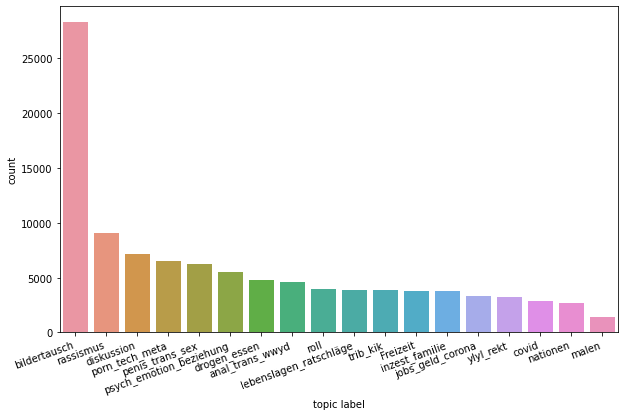

In [214]:
counter = Counter(result_df.labels)
topic_dict = OrderedDict(sorted(counter.items(), key=lambda x: x[1], reverse=True))
plt.figure(figsize=(10,6))
g = sns.barplot(x=list(topic_dict.keys()), y=list(topic_dict.values()), order=list(topic_dict.keys()), orient="v")
g.set_xticklabels(labels=g.get_xticklabels(), rotation=20, horizontalalignment='right')

g.set_ylabel("count")
g.set_xlabel("topic label")
plt.show()


In [208]:
g.get_yticklabels()

[Text(0, 0, 'bildertausch'),
 Text(0, 1, 'rassismus'),
 Text(0, 2, 'diskussion'),
 Text(0, 3, 'porn_tech_meta'),
 Text(0, 4, 'penis_trans_sex'),
 Text(0, 5, 'psych_emotion_beziehung'),
 Text(0, 6, 'drogen_essen'),
 Text(0, 7, 'anal_trans_wwyd'),
 Text(0, 8, 'roll'),
 Text(0, 9, 'lebenslagen_ratschläge'),
 Text(0, 10, 'trib_kik'),
 Text(0, 11, 'Freizeit'),
 Text(0, 12, 'inzest_familie'),
 Text(0, 13, 'jobs_geld_corona'),
 Text(0, 14, 'ylyl_rekt'),
 Text(0, 15, 'covid'),
 Text(0, 16, 'nationen'),
 Text(0, 17, 'malen')]

In [231]:
counter = Counter(result_df.km)
topic_dict = OrderedDict(sorted(counter.items(), key=lambda x: x[1], reverse=True))
plt.figure(figsize=(10,6))
g = sns.barplot(x=list(topic_dict.keys()), y=list(topic_dict.values()), order=list(topic_dict.keys()), orient="v")
g.set_xticklabels(labels=g.get_xticklabels(), rotation=20, horizontalalignment='right')

g.set_ylabel("Count")
g.set_xlabel("Topic number")
plt.show()


AttributeError: 'DataFrame' object has no attribute 'km'

In [176]:
from collections import Counter, OrderedDict

In [173]:
result_df = pd.read_pickle("b_collection_extracted/document_result_df_25tops")

In [174]:
result_df

0         1         2         3         4         5  \
830097224  0.069882  0.076534  0.000000  0.022479  0.051844  0.028320   
828635931  0.058724  0.039216  0.039315  0.039216  0.039216  0.039216   
828806746  0.025240  0.024693  0.023191  0.025465  0.022335  0.157147   
828629011  0.053437  0.017086  0.046074  0.184290  0.077461  0.000000   
828822496  0.118044  0.026436  0.035450  0.063474  0.026982  0.026594   
...             ...       ...       ...       ...       ...       ...   
831569096  0.020463  0.020579  0.021007  0.028131  0.022588  0.047008   
830755068  0.017760  0.000000  0.000000  0.024322  0.000000  0.039147   
828459235  0.000000  0.024387  0.000000  0.010963  0.000000  0.016019   
828957946  0.017050  0.014455  0.026351  0.020430  0.101422  0.015091   
830864445  0.023502  0.027643  0.054468  0.037310  0.206633  0.021941   

                  6         7         8         9  ...        17        18  \
830097224  0.011417  0.017548  0.034530  0.066570  ...  0.026977  0.013597   
828635931  0.039216  0.039216  0.039216  0.039216  ...  0.039216  0.039216   
828806746  0.030441  0.028016  0.165846  0.022658  ...  0.022290  0.031558   
828629011  0.018914  0.049973  0.150124  0.023965  ...  0.000000  0.000000   
828822496  0.021446  0.039645  0.027595  0.025221  ...  0.027549  0.025369   
...             ...       ...       ...       ...  ...       ...       ...   
831569096  0.112389  0.095555  0.022173  0.206631  ...  0.036129  0.020076   
830755068  0.043475  0.011113  0.032861  0.000000  ...  0.000000  0.385584   
828459235  0.194791  0.000000  0.022030  0.013759  ...  0.000000  0.023719   
828957946  0.014687  0.031673  0.035531  0.015752  ...  0.296874  0.017248   
830864445  0.024846  0.024017  0.021404  0.023308  ...  0.098338  0.021859   

                 19        20        21        22        23        24  \
830097224  0.013132  0.029332  0.000000  0.000000  0.010996  0.010017   
828635931  0.039216  0.039216  0.039216  0.039216  0.039216  0.039216   
828806746  0.056152  0.022619  0.058254  0.029106  0.023052  0.025073   
828629011  0.000000  0.027140  0.000000  0.049649  0.021775  0.010953   
828822496  0.108135  0.036802  0.024343  0.029114  0.084837  0.024508   
...             ...       ...       ...       ...       ...       ...   
831569096  0.023088  0.031757  0.022851  0.019949  0.023387  0.038741   
830755068  0.140155  0.000000  0.070907  0.088001  0.000000  0.000000   
828459235  0.000000  0.297269  0.021165  0.155764  0.000000  0.000000   
828957946  0.000000  0.025955  0.000000  0.012190  0.015238  0.014456   
830864445  0.021881  0.024276  0.021363  0.020662  0.039778  0.023700   

           dominant_topic           labels  
830097224              12   porn_tech_meta  
828635931               0     bildertausch  
828806746               8        rassismus  
828629011               3        ylyl_rekt  
828822496               0     bildertausch  
...                   ...              ...  
831569096               9  anal_trans_wwyd  
830755068              18            covid  
828459235              20  penis_trans_sex  
828957946              17     bildertausch  
830864445               4     bildertausch  

[105100 rows x 27 columns]

In [76]:
from scipy.cluster.hierarchy import dendrogram
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering

In [77]:
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
model.fit(result_df.drop(columns="dominant_topic"))

AgglomerativeClustering(distance_threshold=0, n_clusters=None)

In [78]:

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

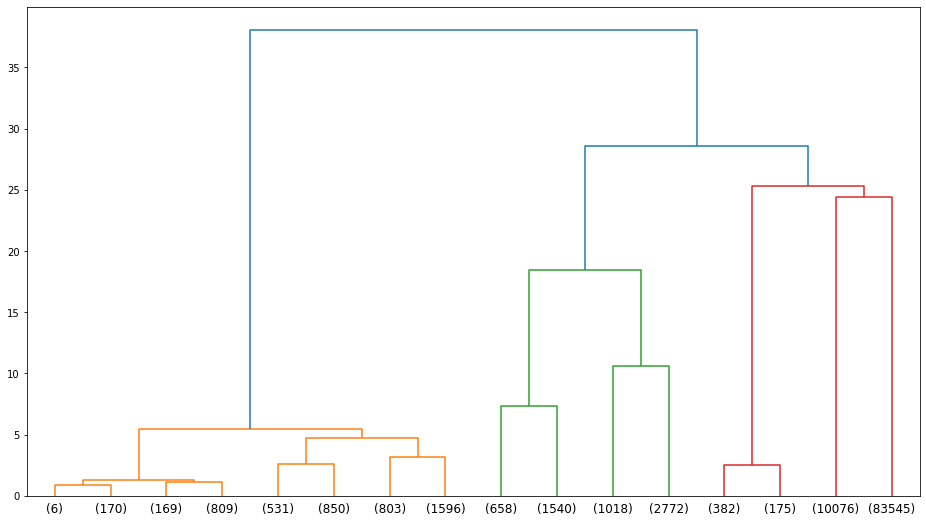

In [81]:
plt.figure(figsize=(16,9))
plot_dendrogram(model, truncate_mode='level', p=3)

In [80]:
plt.show()

In [132]:
result_df

0         1         2         3         4         5  \
830097224  0.069882  0.076534  0.000000  0.022479  0.051844  0.028320   
828635931  0.058724  0.039216  0.039315  0.039216  0.039216  0.039216   
828806746  0.025240  0.024693  0.023191  0.025465  0.022335  0.157147   
828629011  0.053437  0.017086  0.046074  0.184290  0.077461  0.000000   
828822496  0.118044  0.026436  0.035450  0.063474  0.026982  0.026594   
...             ...       ...       ...       ...       ...       ...   
831569096  0.020463  0.020579  0.021007  0.028131  0.022588  0.047008   
830755068  0.017760  0.000000  0.000000  0.024322  0.000000  0.039147   
828459235  0.000000  0.024387  0.000000  0.010963  0.000000  0.016019   
828957946  0.017050  0.014455  0.026351  0.020430  0.101422  0.015091   
830864445  0.023502  0.027643  0.054468  0.037310  0.206633  0.021941   

                  6         7         8         9  ...        17        18  \
830097224  0.011417  0.017548  0.034530  0.066570  ...  0.026977  0.013597   
828635931  0.039216  0.039216  0.039216  0.039216  ...  0.039216  0.039216   
828806746  0.030441  0.028016  0.165846  0.022658  ...  0.022290  0.031558   
828629011  0.018914  0.049973  0.150124  0.023965  ...  0.000000  0.000000   
828822496  0.021446  0.039645  0.027595  0.025221  ...  0.027549  0.025369   
...             ...       ...       ...       ...  ...       ...       ...   
831569096  0.112389  0.095555  0.022173  0.206631  ...  0.036129  0.020076   
830755068  0.043475  0.011113  0.032861  0.000000  ...  0.000000  0.385584   
828459235  0.194791  0.000000  0.022030  0.013759  ...  0.000000  0.023719   
828957946  0.014687  0.031673  0.035531  0.015752  ...  0.296874  0.017248   
830864445  0.024846  0.024017  0.021404  0.023308  ...  0.098338  0.021859   

                 19        20        21        22        23        24  \
830097224  0.013132  0.029332  0.000000  0.000000  0.010996  0.010017   
828635931  0.039216  0.039216  0.039216  0.039216  0.039216  0.039216   
828806746  0.056152  0.022619  0.058254  0.029106  0.023052  0.025073   
828629011  0.000000  0.027140  0.000000  0.049649  0.021775  0.010953   
828822496  0.108135  0.036802  0.024343  0.029114  0.084837  0.024508   
...             ...       ...       ...       ...       ...       ...   
831569096  0.023088  0.031757  0.022851  0.019949  0.023387  0.038741   
830755068  0.140155  0.000000  0.070907  0.088001  0.000000  0.000000   
828459235  0.000000  0.297269  0.021165  0.155764  0.000000  0.000000   
828957946  0.000000  0.025955  0.000000  0.012190  0.015238  0.014456   
830864445  0.021881  0.024276  0.021363  0.020662  0.039778  0.023700   

           dominant_topic           labels  
830097224              12   porn_tech_meta  
828635931               0     bildertausch  
828806746               8        rassismus  
828629011               3        ylyl_rekt  
828822496               0     bildertausch  
...                   ...              ...  
831569096               9  anal_trans_wwyd  
830755068              18            covid  
828459235              20  penis_trans_sex  
828957946              17     bildertausch  
830864445               4     bildertausch  

[105100 rows x 27 columns]

In [216]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
from sklearn.cluster import KMeans
result_df = pd.read_pickle("b_collection_extracted/document_result_df_25tops")
X = result_df.drop(columns= ["dominant_topic", "labels"])


In [158]:
X

0         1         2         3         4         5   \
830097224  0.037051  0.022928  0.018190  0.000000  0.329149  0.020258   
828635931  0.049020  0.049020  0.049020  0.049182  0.068408  0.049020   
828806746  0.032071  0.038633  0.072025  0.028706  0.030556  0.036756   
828629011  0.014446  0.251060  0.013481  0.059829  0.141474  0.030384   
828822496  0.028662  0.055851  0.128970  0.061233  0.113967  0.030103   
...             ...       ...       ...       ...       ...       ...   
831569096  0.039164  0.031775  0.028262  0.025739  0.031378  0.111469   
830755068  0.000000  0.028947  0.151204  0.000000  0.000000  0.043736   
828459235  0.020987  0.020850  0.000000  0.000000  0.020736  0.245779   
828957946  0.023606  0.028881  0.013878  0.027145  0.035768  0.016553   
830864445  0.028715  0.038382  0.027670  0.077051  0.071484  0.029391   

                 6         7         8         9         10        11  \
830097224  0.040648  0.051258  0.027013  0.101536  0.000000  0.017634   
828635931  0.049020  0.049020  0.049020  0.049020  0.049020  0.049020   
828806746  0.037267  0.030372  0.174993  0.029719  0.177778  0.031602   
828629011  0.141135  0.023445  0.000000  0.045071  0.000000  0.000000   
828822496  0.038423  0.032932  0.038147  0.071043  0.032018  0.026983   
...             ...       ...       ...       ...       ...       ...   
831569096  0.023536  0.027176  0.071944  0.027165  0.029251  0.052872   
830755068  0.084799  0.010438  0.028169  0.013511  0.072330  0.047951   
828459235  0.157392  0.019472  0.015906  0.320199  0.013248  0.010821   
828957946  0.031625  0.025970  0.022216  0.057812  0.019387  0.047133   
830864445  0.026493  0.032713  0.027780  0.033387  0.026965  0.031859   

                 12        13        14        15        16        17  \
830097224  0.019684  0.035785  0.019994  0.085983  0.058109  0.073910   
828635931  0.049020  0.049020  0.049077  0.049020  0.049020  0.049020   
828806746  0.028098  0.033879  0.028831  0.056091  0.027797  0.027767   
828629011  0.016807  0.070335  0.036985  0.000000  0.084959  0.025231   
828822496  0.055526  0.061635  0.047417  0.046824  0.036337  0.028205   
...             ...       ...       ...       ...       ...       ...   
831569096  0.033063  0.114090  0.033593  0.030401  0.029690  0.208559   
830755068  0.000000  0.014556  0.000000  0.041607  0.000000  0.000000   
828459235  0.000000  0.000000  0.014994  0.019865  0.000000  0.036677   
828957946  0.292078  0.059193  0.067158  0.013564  0.158725  0.022639   
830864445  0.054619  0.030734  0.040909  0.044977  0.237215  0.058257   

                 18        19  
830097224  0.016372  0.011472  
828635931  0.049020  0.049020  
828806746  0.042066  0.034995  
828629011  0.000000  0.000000  
828822496  0.040844  0.024882  
...             ...       ...  
831569096  0.025085  0.025788  
830755068  0.411854  0.000000  
828459235  0.035143  0.000000  
828957946  0.018465  0.018203  
830864445  0.027376  0.054022  

[105100 rows x 20 columns]

In [218]:
wcss = [] 
for i in range(1, 24): 
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42, n_jobs = 20, max_iter=500)
    kmeans.fit(X) 
    wcss.append(kmeans.inertia_)

/home/hengelhardt/masterarbeit/.venv/lib/python3.6/site-packages/sklearn/cluster/_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)
/home/hengelhardt/masterarbeit/.venv/lib/python3.6/site-packages/sklearn/cluster/_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)
/home/hengelhardt/masterarbeit/.venv/lib/python3.6/site-packages/sklearn/cluster/_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)
/home/hengelhardt/masterarbeit/.venv/lib/python3.6/site-packages/sklearn/cluster/_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25

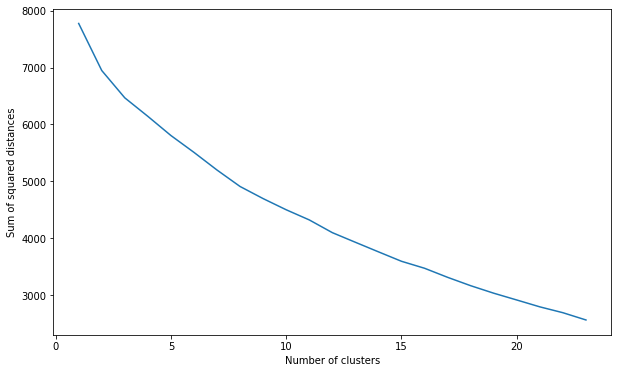

In [227]:
plt.figure(figsize=(10,6))
plt.plot(range(1, 24), wcss)
plt.xlabel('Number of clusters')
plt.ylabel('Sum of squared distances') 
plt.show()

In [162]:
kmeans = KMeans(n_clusters = 8, init = "k-means++", random_state = 42)
y_kmeans = kmeans.fit_predict(X)

In [163]:
result_df["km"] = y_kmeans

In [233]:
result_df = pd.read_pickle("b_collection_extracted/result_df_dist_clust")

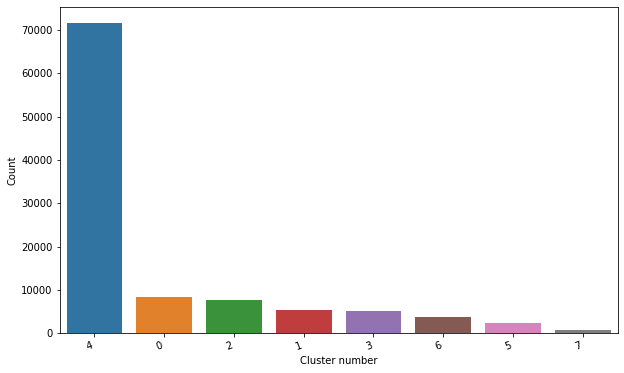

In [234]:
counter = Counter(result_df.km)
topic_dict = OrderedDict(sorted(counter.items(), key=lambda x: x[1], reverse=True))
plt.figure(figsize=(10,6))
g = sns.barplot(x=list(topic_dict.keys()), y=list(topic_dict.values()), order=list(topic_dict.keys()), orient="v")
g.set_xticklabels(labels=g.get_xticklabels(), rotation=20, horizontalalignment='right')

g.set_ylabel("Count")
g.set_xlabel("Cluster number")
plt.show()


In [164]:
result_df.to_pickle("b_collection_extracted/result_df_dist_clust")

In [147]:
import pysubgroup as ps
import pandas as pd
from graph_pipeline.main import *
from tqdm.auto import tqdm
import numpy as np
import multiprocessing as mp
from itertools import product
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from collections import Counter
import seaborn as sns
import statsmodels.api as sm


def filter_on_stats(stat_df, min_replies=10, max_replies=350, language='en', acyclic=True):
    filter_array = np.logical_and(stat_df.replies >= min_replies ,stat_df.language == language)
    filter_array = np.logical_and(filter_array, stat_df.is_acyclic == acyclic)
    filter_array = np.logical_and(filter_array,stat_df.replies <= max_replies)
    filter_array = filter_array.to_numpy()
    return filter_array

def drop_useless(graph_feature_df):
    return graph_feature_df.drop(columns=["network_diameter", "network_radius", "closeness_centralization", "102", "111D", "111U", 
                                          "030C", "201", "120D", "120U", "120C", "210", "300" ])

In [166]:
graph_features_all = pd.read_pickle("b_collection_extracted/graph_features_all")
stat_df = pd.read_pickle("b_collection_extracted/stat_df")
#result_df = pd.read_pickle("b_collection_extracted/document_result_df_25tops")
graph_features_all['replies'] = stat_df.set_index('thread_id').replies
clean_features = drop_useless(graph_features_all).drop(columns=["max_degree", "003"])
clean_features = clean_features[filter_on_stats(stat_df)]
stat_df = stat_df[filter_on_stats(stat_df)]
stat_df = stat_df.join(result_df.dominant_topic, on='thread_id')
clean_features = clean_features.join(result_df.km).drop(columns="board")
#clean_features_label = clean_features.join(result_df.labels)

In [155]:
clean_features

average_degree   density  longest_path  transitivity  \
830097224        2.180180  0.009910      0.144144      0.272727   
828635931        1.904762  0.047619      0.047619      0.000000   
828806746        1.900000  0.050000      0.250000      0.000000   
828629011        2.172107  0.003232      0.056380      0.202703   
828822496        1.913043  0.043478      0.173913      0.000000   
...                   ...       ...           ...           ...   
831569096        1.857143  0.071429      0.142857      0.000000   
830755068        2.070588  0.006126      0.064706      0.076923   
828459235        2.041667  0.021720      0.145833      0.250000   
828957946        2.271493  0.005162      0.113122      0.108696   
830864445        2.271186  0.019579      0.305085      0.153846   

           average_clustering  degree_centralization  \
830097224            0.025686               0.257548   
828635931            0.000000               1.000000   
828806746            0.000000               0.590643   
828629011            0.028239               0.319838   
828822496            0.000000               0.352814   
...                       ...                    ...   
831569096            0.000000               0.910256   
830755068            0.005105               0.292970   
828459235            0.024306               0.398705   
828957946            0.023508               0.370299   
830864445            0.041957               0.298548   

           betweenness_centralization       012      021D      021U      021C  \
830097224                    0.007899  0.054293  0.000023  0.002083  0.000437   
828635931                    0.000000  0.000000  0.000000  0.142857  0.000000   
828806746                    0.014620  0.171930  0.000000  0.057895  0.006140   
828629011                    0.001671  0.017396  0.000003  0.000947  0.000045   
828822496                    0.008756  0.202146  0.000000  0.022021  0.007340   
...                               ...       ...       ...       ...       ...   
831569096                    0.006410  0.060440  0.000000  0.181319  0.002747   
830755068                    0.001819  0.032922  0.000014  0.001742  0.000158   
828459235                    0.009664  0.103434  0.000058  0.011563  0.001735   
828957946                    0.004207  0.026782  0.000020  0.001967  0.000101   
830864445                    0.039531  0.102095  0.000277  0.005691  0.001538   

               030T board replies  
830097224  0.000027     b     110  
828635931  0.000000     b      20  
828806746  0.000000     b      19  
828629011  0.000002     b     336  
828822496  0.000000     b      22  
...             ...   ...     ...  
831569096  0.000000     b      13  
830755068  0.000002     b     169  
828459235  0.000058     b      47  
828957946  0.000006     b     219  
830864445  0.000123     b      58  

[105100 rows x 14 columns]

25

In [153]:
graph_features_all = clean_features
graph_features_all['replies'] = stat_df.set_index('thread_id').replies
scaler = StandardScaler()


clf = RandomForestClassifier(random_state=42)

cv = StratifiedKFold(
    n_splits=5
)
cv_results_rf = {}
for min_replies, max_replies in tqdm([(10, 50), (10, 100), (10, 350), (50,100), 
                                      (50, 150), (50, 250), (50, 350), (100, 150), 
                                      (100, 250), (100, 350), (150,250), (150, 300), 
                                      (200, 350), (250, 350)]):
    print(min_replies, max_replies)
    filter_array = filter_on_stats(stat_df, min_replies=min_replies, max_replies=max_replies)
    graph_features = graph_features_all.loc[filter_array]
    graph_features = graph_features.dropna()
    X = graph_features.drop(columns=["km", "replies"]).to_numpy()
    y = graph_features.km.to_numpy()
    scaler.fit(X)
    X_transformed = scaler.transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.2, 
                                                        random_state=42, stratify=y)
    count = Counter(y_train)
    
    param_grid = { 
    'n_estimators': [100, 150, 200],
    'max_features': ['auto'],
    'max_depth' : [ None],
    'criterion' :['gini'],
    'class_weight': ['balanced', {label:1/count[label] for label in count.keys()}],
    'random_state': [42]
    }

    search = GridSearchCV(
        estimator=clf, param_grid=param_grid,
        scoring='f1_macro', cv=cv,
        n_jobs=10, refit = True
    )
    search.fit(X_train, y_train)
    print(search.best_params_)
    key = f"{min_replies}-{max_replies}"
    cv_results_rf[key] = {"model":search, 
                      'X_test': X_test, 
                      'X_train': X_train, 
                      'y_test':y_test, 
                      "y_train":y_train
                     }
    print(classification_report(cv_results_rf[key]['y_test'], cv_results_rf[key]['model'].predict(cv_results_rf[key]['X_test'])))

  0%|          | 0/14 [00:00<?, ?it/s]

10 50


/home/hengelhardt/masterarbeit/.venv/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


{'class_weight': {4: 2.4125452352231604e-05, 0: 0.00024894199651481205, 6: 0.00043252595155709344, 3: 0.00045004500450045, 1: 0.0003913894324853229, 5: 0.0017667844522968198, 2: 0.0036900369003690036, 7: 0.007633587786259542}, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'n_estimators': 150, 'random_state': 42}
              precision    recall  f1-score   support

           0       0.07      0.03      0.05      1004
           1       0.05      0.05      0.05       639
           2       0.00      0.00      0.00        68
           3       0.04      0.03      0.04       556
           4       0.76      0.73      0.74     10362
           5       0.03      0.05      0.03       141
           6       0.04      0.05      0.05       578
           7       0.01      0.24      0.02        33

    accuracy                           0.58     13381
   macro avg       0.12      0.15      0.12     13381
weighted avg       0.60      0.58      0.59     13381

10 100


/home/hengelhardt/masterarbeit/.venv/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


{'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'n_estimators': 100, 'random_state': 42}
              precision    recall  f1-score   support

           0       0.08      0.03      0.04      1297
           1       0.06      0.04      0.05       830
           2       0.09      0.02      0.03       175
           3       0.07      0.04      0.05       742
           4       0.73      0.79      0.76     11894
           5       0.04      0.04      0.04       244
           6       0.04      0.03      0.04       682
           7       0.01      0.08      0.01        50

    accuracy                           0.60     15914
   macro avg       0.14      0.13      0.13     15914
weighted avg       0.56      0.60      0.58     15914

10 350


/home/hengelhardt/masterarbeit/.venv/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


{'class_weight': {4: 1.743922430330299e-05, 0: 0.00015019525382997898, 1: 0.00023696682464454977, 6: 0.00033500837520938025, 3: 0.00023980815347721823, 2: 0.00016204829039053638, 5: 0.0005399568034557236, 7: 0.001466275659824047}, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'n_estimators': 100, 'random_state': 42}
              precision    recall  f1-score   support

           0       0.10      0.03      0.05      1664
           1       0.06      0.03      0.04      1055
           2       0.82      0.65      0.73      1543
           3       0.16      0.09      0.11      1043
           4       0.72      0.83      0.77     14335
           5       0.34      0.18      0.23       463
           6       0.04      0.04      0.04       746
           7       0.15      0.37      0.21       171

    accuracy                           0.63     21020
   macro avg       0.30      0.28      0.27     21020
weighted avg       0.58      0.63      0.60     21020

50 100
{'clas

/home/hengelhardt/masterarbeit/.venv/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


{'class_weight': {4: 6.205013651030033e-05, 0: 0.00037257824143070045, 2: 0.00016923337282112033, 6: 0.001455604075691412, 1: 0.0005913660555884093, 3: 0.0005055611729019212, 7: 0.0018115942028985507, 5: 0.0007710100231303007}, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'n_estimators': 100, 'random_state': 42}
              precision    recall  f1-score   support

           0       0.20      0.02      0.04       671
           1       0.10      0.01      0.02       423
           2       0.80      0.68      0.74      1478
           3       0.39      0.18      0.25       494
           4       0.63      0.92      0.75      4029
           5       0.62      0.25      0.36       324
           6       0.00      0.00      0.00       172
           7       0.65      0.38      0.48       138

    accuracy                           0.64      7729
   macro avg       0.42      0.31      0.33      7729
weighted avg       0.57      0.64      0.57      7729

100 150
{'class_

/home/hengelhardt/masterarbeit/.venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/hengelhardt/masterarbeit/.venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/hengelhardt/masterarbeit/.venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

{'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'n_estimators': 100, 'random_state': 42}
              precision    recall  f1-score   support

           0       0.17      0.00      0.01       226
           1       0.09      0.01      0.01       146
           2       0.73      0.53      0.61       604
           3       0.34      0.16      0.22       183
           4       0.64      0.92      0.75      1814
           5       0.53      0.18      0.27       109
           6       0.00      0.00      0.00        55
           7       0.50      0.02      0.04        52

    accuracy                           0.64      3189
   macro avg       0.37      0.23      0.24      3189
weighted avg       0.56      0.64      0.57      3189

100 350


/home/hengelhardt/masterarbeit/.venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/hengelhardt/masterarbeit/.venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/hengelhardt/masterarbeit/.venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

{'class_weight': {0: 0.0006775067750677507, 2: 0.00018258170531312764, 5: 0.0011363636363636363, 4: 0.00010169836265636123, 1: 0.0011037527593818985, 7: 0.002074688796680498, 3: 0.0008244023083264633, 6: 0.003861003861003861}, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'n_estimators': 100, 'random_state': 42}
              precision    recall  f1-score   support

           0       0.20      0.02      0.04       369
           1       0.22      0.04      0.06       227
           2       0.80      0.72      0.76      1370
           3       0.37      0.21      0.27       303
           4       0.64      0.89      0.74      2458
           5       0.70      0.41      0.52       220
           6       0.00      0.00      0.00        65
           7       0.71      0.45      0.55       120

    accuracy                           0.66      5132
   macro avg       0.45      0.34      0.37      5132
weighted avg       0.61      0.66      0.62      5132

150 250


/home/hengelhardt/masterarbeit/.venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/hengelhardt/masterarbeit/.venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/hengelhardt/masterarbeit/.venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

{'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'n_estimators': 100, 'random_state': 42}
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       120
           1       0.00      0.00      0.00        69
           2       0.77      0.62      0.69       504
           3       0.39      0.25      0.31        95
           4       0.67      0.91      0.77      1199
           5       0.75      0.11      0.20        53
           6       0.00      0.00      0.00        28
           7       0.00      0.00      0.00        42

    accuracy                           0.68      2110
   macro avg       0.32      0.24      0.25      2110
weighted avg       0.60      0.68      0.62      2110

150 300


/home/hengelhardt/masterarbeit/.venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/hengelhardt/masterarbeit/.venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/hengelhardt/masterarbeit/.venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

{'class_weight': {2: 0.00022993791676247414, 3: 0.002074688796680498, 4: 0.00017670966601873123, 1: 0.002890173410404624, 0: 0.0015625, 7: 0.005050505050505051, 6: 0.007874015748031496, 5: 0.0036496350364963502}, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'n_estimators': 150, 'random_state': 42}
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       160
           1       0.23      0.03      0.06        86
           2       0.84      0.75      0.79      1087
           3       0.39      0.21      0.28       121
           4       0.65      0.89      0.76      1415
           5       0.50      0.09      0.15        68
           6       0.00      0.00      0.00        32
           7       0.79      0.22      0.34        50

    accuracy                           0.70      3019
   macro avg       0.43      0.28      0.30      3019
weighted avg       0.65      0.70      0.66      3019

200 350


/home/hengelhardt/masterarbeit/.venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/hengelhardt/masterarbeit/.venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/hengelhardt/masterarbeit/.venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

{'class_weight': {4: 0.00021963540522732265, 2: 0.0002221235006663705, 0: 0.0013280212483399733, 7: 0.003125, 5: 0.0018248175182481751, 1: 0.0023584905660377358, 3: 0.0015479876160990713, 6: 0.012658227848101266}, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'n_estimators': 200, 'random_state': 42}


/home/hengelhardt/masterarbeit/.venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/hengelhardt/masterarbeit/.venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/hengelhardt/masterarbeit/.venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

              precision    recall  f1-score   support

           0       0.40      0.05      0.09       188
           1       0.33      0.04      0.07       106
           2       0.82      0.84      0.83      1126
           3       0.44      0.35      0.39       162
           4       0.64      0.81      0.72      1139
           5       0.77      0.58      0.66       137
           6       0.00      0.00      0.00        19
           7       0.74      0.68      0.71        80

    accuracy                           0.70      2957
   macro avg       0.52      0.42      0.43      2957
weighted avg       0.67      0.70      0.67      2957

250 350
{'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'n_estimators': 100, 'random_state': 42}
              precision    recall  f1-score   support

           0       0.37      0.08      0.13       144
           1       0.19      0.06      0.09        82
           2       0.83      0.88      0.85 

/home/hengelhardt/masterarbeit/.venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/hengelhardt/masterarbeit/.venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/hengelhardt/masterarbeit/.venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

In [ ]:
stat_df.join(result_df.km, on='thread_id')

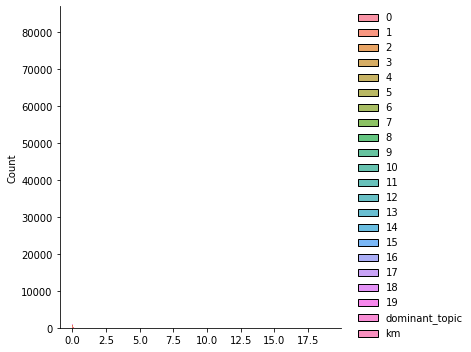

In [169]:
sns.displot(result_df)